In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from matplotlib import pyplot
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import explained_variance_score, mean_squared_error, r2_score, mean_absolute_error
from collections import Counter
from keras import callbacks
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout,InputLayer
from tensorflow.keras.models import Sequential
from keras.layers import BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras import backend
from random import shuffle
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import RMSprop
import warnings
warnings.filterwarnings("ignore")

Reading Dataset and Feature Elimination
- Read the dataset properly - Print the overview of the data (statistical summary, shape, info, etc) - Eliminate the unique features from the dataset with proper reasoning

In [ ]:
#Read in the data from excel (I converted form csv)
data = pd.read_excel('/content/drive/MyDrive/Churn.xlsx')

In [ ]:
data.head() #see a small sample of the data

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [ ]:
#Information about the data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [ ]:
data.shape#what is the shape of the data

(10000, 14)

In [ ]:
#finding the null values
data.isnull().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

No NA so no need to drop NA, check duplicates

In [ ]:
duplicate = data[data.duplicated()]
duplicate

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited


Also no duplicates so no need to drop those either

In [ ]:
#Checking the dtypes of the variables in the data
data.dtypes

RowNumber            int64
CustomerId           int64
Surname             object
CreditScore          int64
Geography           object
Gender              object
Age                  int64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
Exited               int64
dtype: object

No date time or other suspisious dtypes

In [ ]:
data.drop(['RowNumber','CustomerId','Surname'],axis=1,inplace=True)
#Row number is not real data so I don't need it. It is noise. Surname and CustomerId I am dropping for a few reasons 1) it is not at all related to anything 2) customers may not like having it used

Perform an Exploratory Data Analysis on the data
- Checked whether the dataset is balanced or not - Bivariate analysis - Use appropriate visualizations to identify the patterns and insights - Any other exploratory deep dive

Univariable

In [ ]:
# function to create labeled barplots


def labeled_barplot(data, feature, perc=False, n=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(data[feature])  # length of the column
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 1, 5))
    else:
        plt.figure(figsize=(n + 1, 5))

    plt.xticks(rotation=90, fontsize=15)
    ax = sns.countplot(
        data=data,
        x=feature,
        palette="Paired",
        order=data[feature].value_counts().index[:n].sort_values(),
    )

    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
        )  # annotate the percentage

    plt.show()  # show the plot

In [ ]:
# function to plot a boxplot and a histogram along the same scale.

#lets look at a boxplot and histogram to see if each vairable is "normal"
def histogram_boxplot(data, feature, figsize=(12, 7), kde=False, bins=None):
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (12,7))
    kde: whether to the show density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        data=data, x=feature, ax=ax_box2, showmeans=True, color="violet"
    )  # boxplot will be created and a star will indicate the mean value of the column
    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins, palette="winter"
    ) if bins else sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2
    )  # For histogram
    # Add mean to the histogram
    ax_hist2.axvline(
        data[feature].median(), color="black", linestyle="-"
    )  # Add median to the histogram

In [ ]:
data.head() # I want to be easily able to see this while working

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


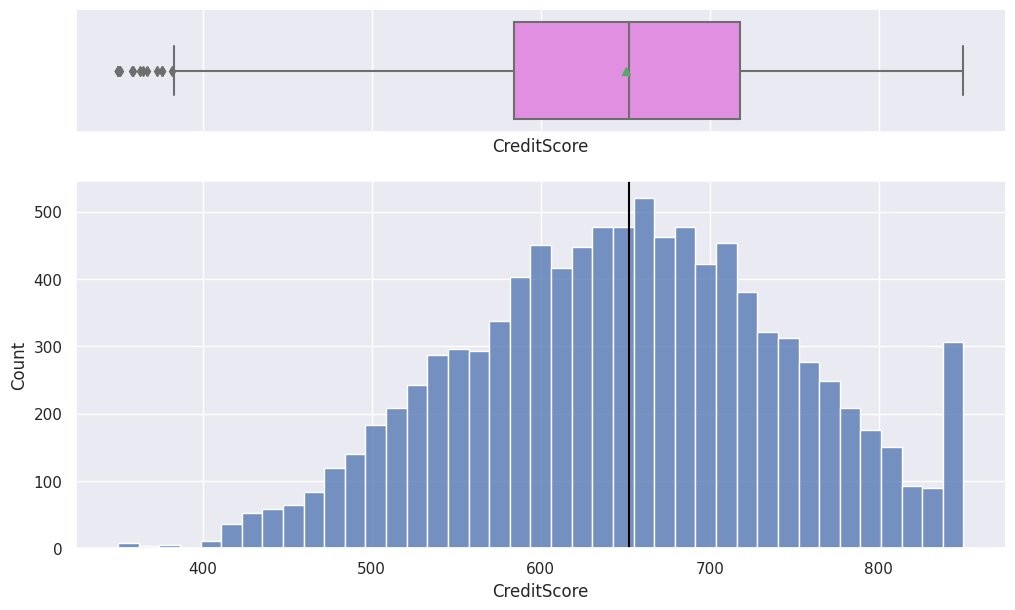

In [ ]:
histogram_boxplot(data, 'CreditScore')#plot credit score

Pretty regular most people around 650 with some outliers below 400. Mean and median are very close so it is pretty balanced

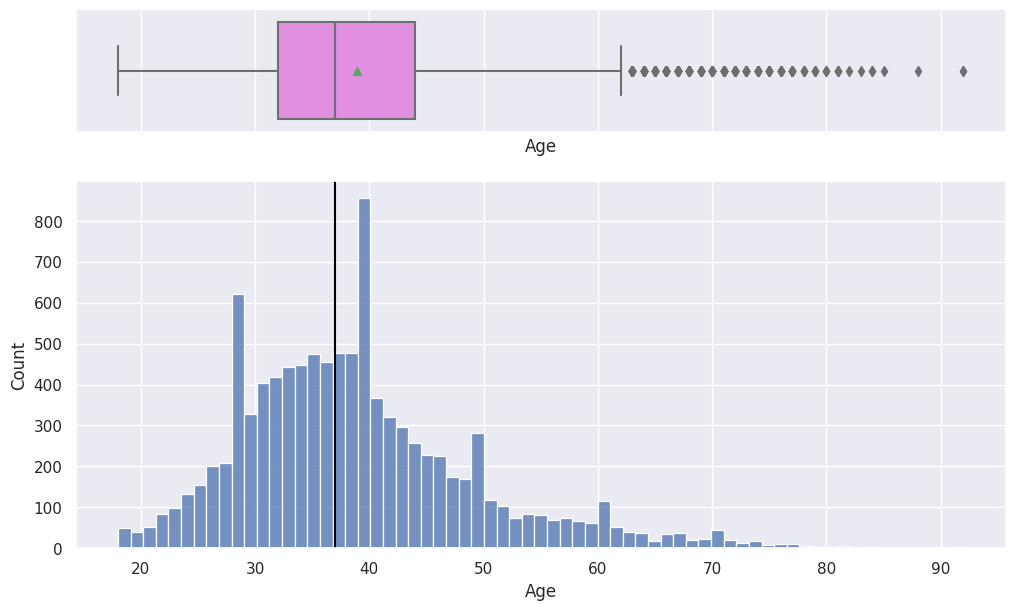

In [ ]:
histogram_boxplot(data, 'Age')#plot credit score

Mean and median a little far off, median being about 36 and mean 38. There are many outliers above 60

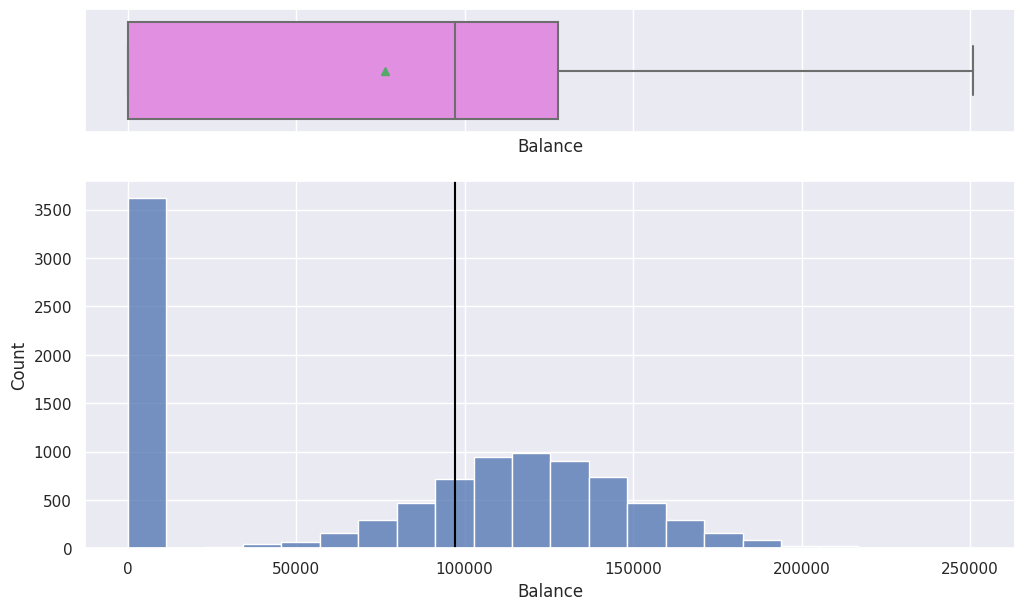

In [ ]:
histogram_boxplot(data, 'Balance')#plot credit score


Balance not balances (ironic) with the mean being 7,5000 and the median 10,000 (roughly) their are a lot of people at 0 (35% it seems)

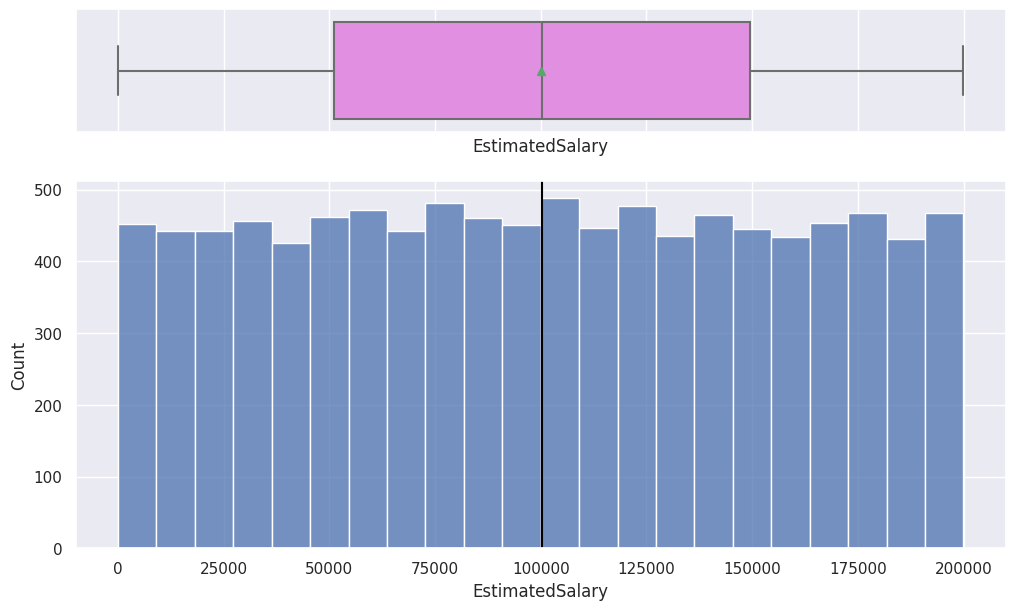

In [ ]:
histogram_boxplot(data, 'EstimatedSalary')#plot credit score

A different kind of distibution but is balanced. we shouls see a nice normal dist or even one consentrated lower, perhaps we appeal to high income people?

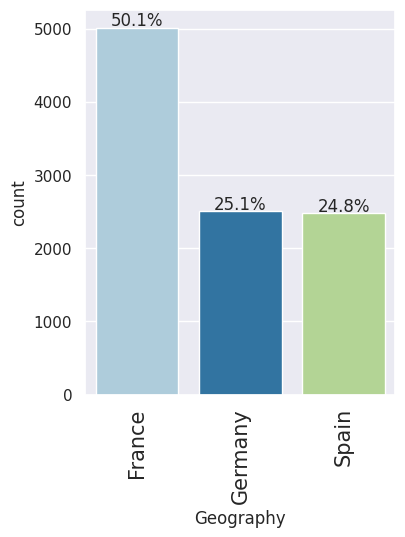

In [ ]:
labeled_barplot(data, "Geography", perc=True)

About 1/2 in France. Other's 50% between Germany and Spain.

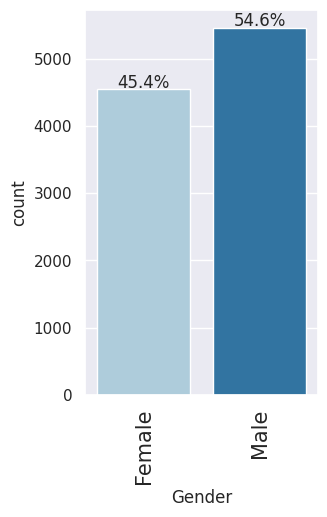

In [ ]:
labeled_barplot(data, "Gender", perc=True)

Slightly more males than females

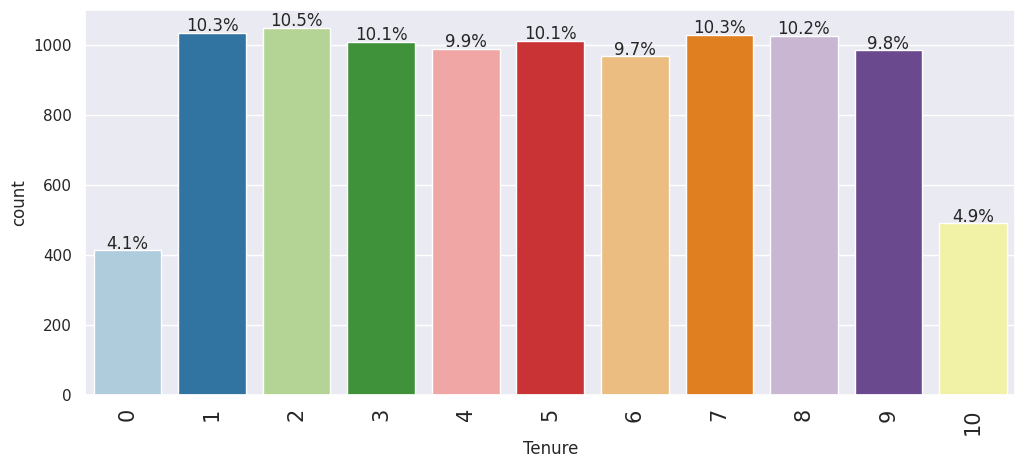

In [ ]:
labeled_barplot(data, "Tenure", perc=True)

4% new and 5% from the begining otherwse we see about the same 10% in each

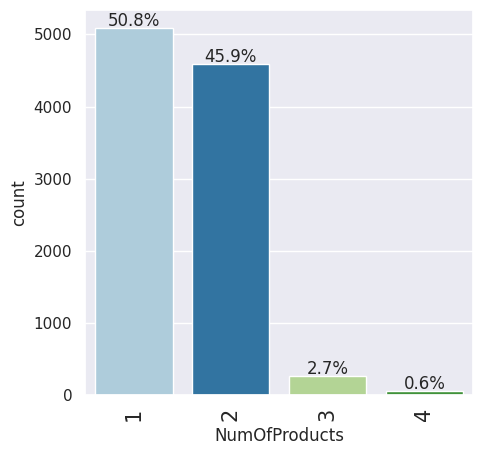

In [ ]:
labeled_barplot(data, "NumOfProducts", perc=True)

half only have one, 45% two. Almost no one has more than that

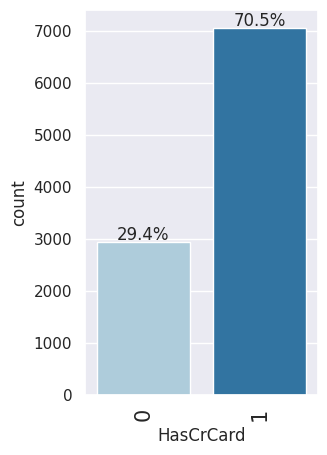

In [ ]:
labeled_barplot(data, "HasCrCard", perc=True)

Majoroty (almost vast) have our cr card

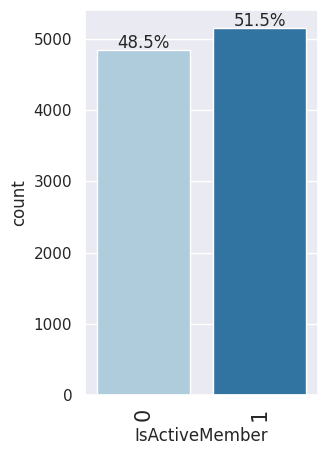

In [ ]:
labeled_barplot(data, "IsActiveMember", perc=True)

Slightly more active than not

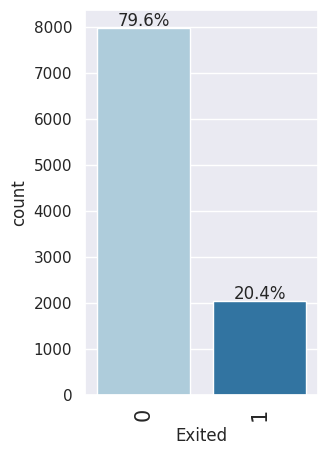

In [ ]:
labeled_barplot(data, "Exited", perc=True)

Vast majority still with us but we have lost a little over 1/5

Bivariate

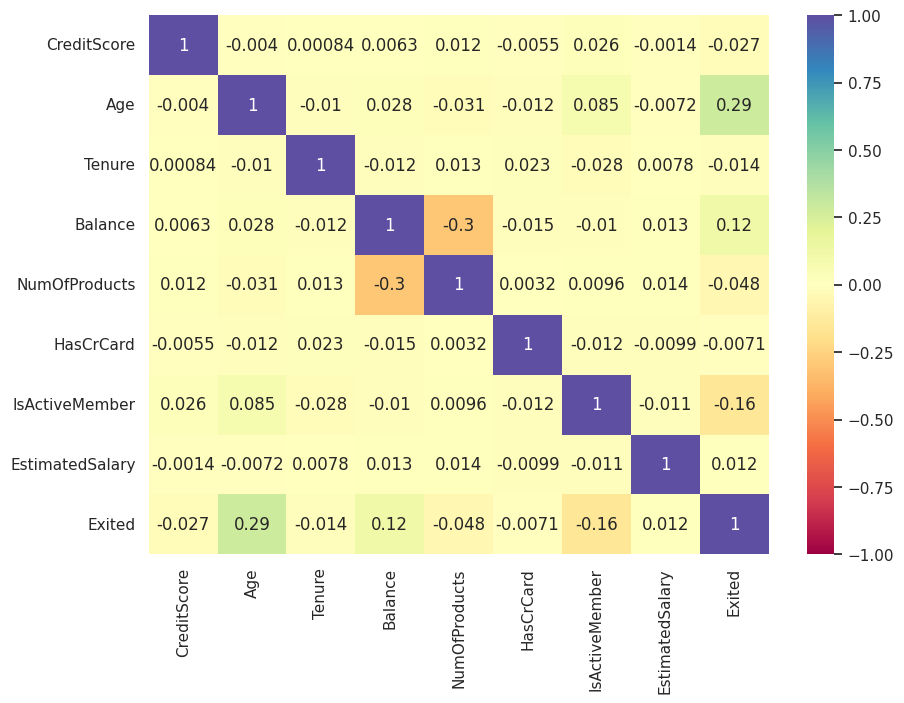

In [ ]:
plt.figure(figsize=(10,7))
sns.heatmap(data.corr(),annot=True,vmin=-1,vmax=1,fmt='.2g',cmap="Spectral")# create a heatmap
plt.show()
#the heatmap will show us if any values are strongly correlated

No really strong correlations. Num of products and balance have a slightly negative relation and age and exited are slightly positve. This may mean that having more than one product depletes an account and that old people are closing their accounts.

Exit is our vairable of interets so plot vs that

<Figure size 1500x1500 with 0 Axes>

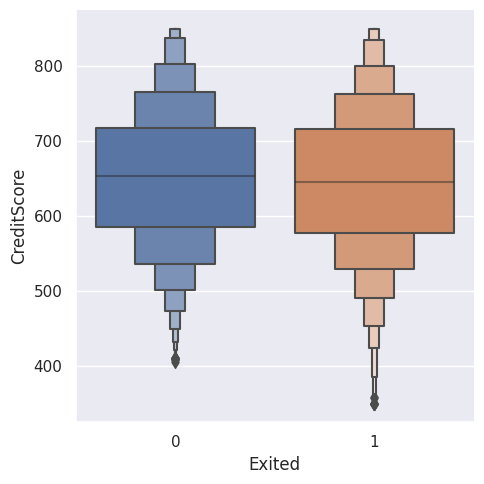

In [ ]:
plt.figure(figsize=(15,15))#ex
sns.catplot(x='Exited',y='CreditScore',data=data.sort_values('Exited',ascending=False),kind='boxen')

Average score is the same, but those with very low scores seem more likely to exit

<Figure size 1500x1500 with 0 Axes>

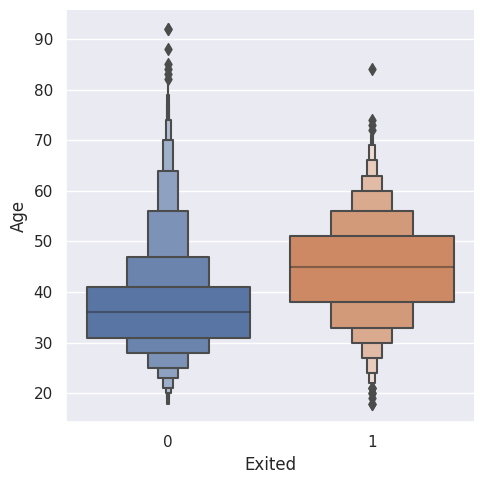

In [ ]:
plt.figure(figsize=(15,15))#ex
sns.catplot(x='Exited',y='Age',data=data.sort_values('Exited',ascending=False),kind='boxen')

Thos who are older are more likely to exit

<Figure size 1500x1500 with 0 Axes>

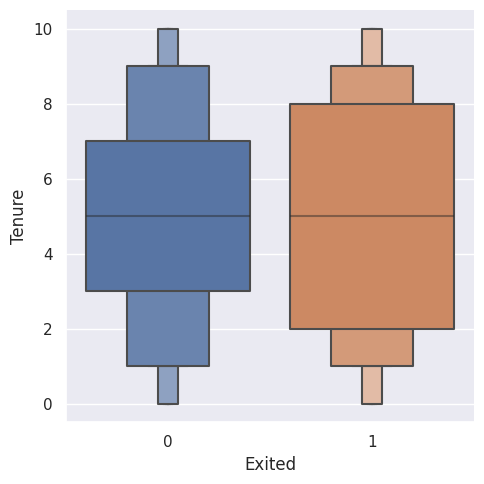

In [ ]:
plt.figure(figsize=(15,15))#ex
sns.catplot(x='Exited',y='Tenure',data=data.sort_values('Exited',ascending=False),kind='boxen')

No real different, but the IQR for 0 is smaller so perhaps those who are in the middle may be more likely to exit

<Figure size 1500x1500 with 0 Axes>

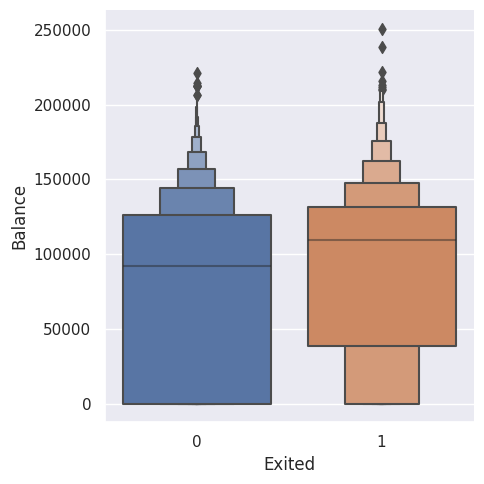

In [ ]:
plt.figure(figsize=(15,15))#ex
sns.catplot(x='Exited',y='Balance',data=data.sort_values('Exited',ascending=False),kind='boxen')

Higher balance is more likely to leave

<Figure size 1500x1500 with 0 Axes>

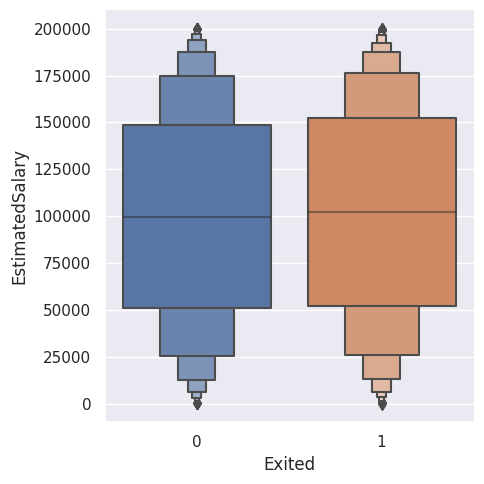

In [ ]:
plt.figure(figsize=(15,15))#ex
sns.catplot(x='Exited',y='EstimatedSalary',data=data.sort_values('Exited',ascending=False),kind='boxen')

No noticable difference

In [ ]:
def stacked_barplot(data, predictor, target):#better for comparing cateogries
    """
    Print the category counts and plot a stacked bar chart

    data: dataframe
    predictor: independent variable
    target: target variable
    """
    count = data[predictor].nunique()
    sorter = data[target].value_counts().index[-1]
    tab1 = pd.crosstab(data[predictor], data[target], margins=True).sort_values(
        by=sorter, ascending=False
    )
    print(tab1)
    print("-" * 120)
    tab = pd.crosstab(data[predictor], data[target], normalize="index").sort_values(
        by=sorter, ascending=False
    )
    tab.plot(kind="bar", stacked=True, figsize=(count + 5, 6))
    plt.legend(
        loc="lower left", frameon=False,
    )
    plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
    plt.show()

Exited            0     1    All
NumOfProducts                   
All            7963  2037  10000
1              3675  1409   5084
2              4242   348   4590
3                46   220    266
4                 0    60     60
------------------------------------------------------------------------------------------------------------------------


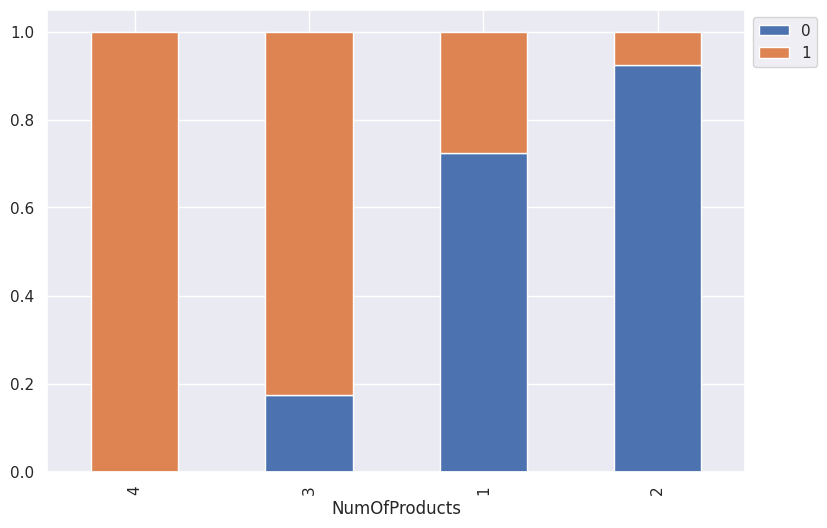

In [ ]:
stacked_barplot(data, "NumOfProducts","Exited")

No one with 4 stayed, only 17% if thise with 3 stayed. 35% of those with 1 left and only 8% of those with 2 left.

Exited        0     1    All
HasCrCard                   
All        7963  2037  10000
1          5631  1424   7055
0          2332   613   2945
------------------------------------------------------------------------------------------------------------------------


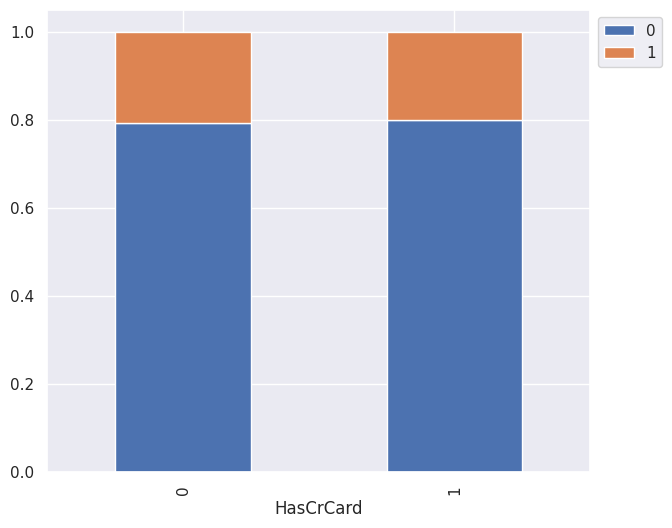

In [ ]:
stacked_barplot(data, "HasCrCard","Exited")

No difference here

Exited             0     1    All
IsActiveMember                   
All             7963  2037  10000
0               3547  1302   4849
1               4416   735   5151
------------------------------------------------------------------------------------------------------------------------


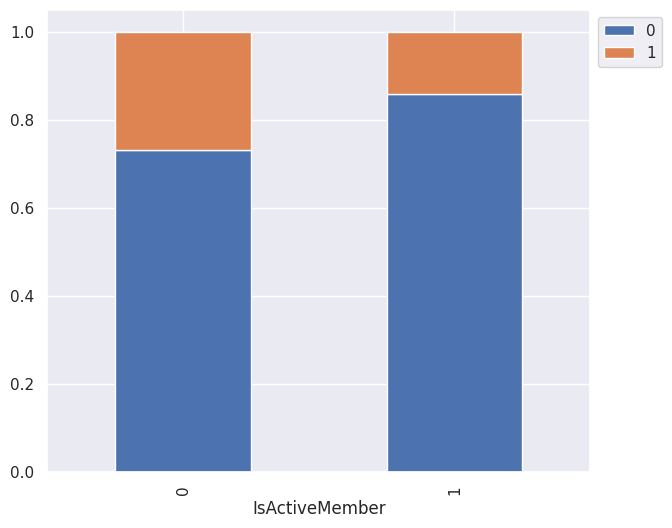

In [ ]:
stacked_barplot(data, "IsActiveMember","Exited")

27% of inactive left and only 14% of active left

Exited     0     1    All
Gender                   
All     7963  2037  10000
Female  3404  1139   4543
Male    4559   898   5457
------------------------------------------------------------------------------------------------------------------------


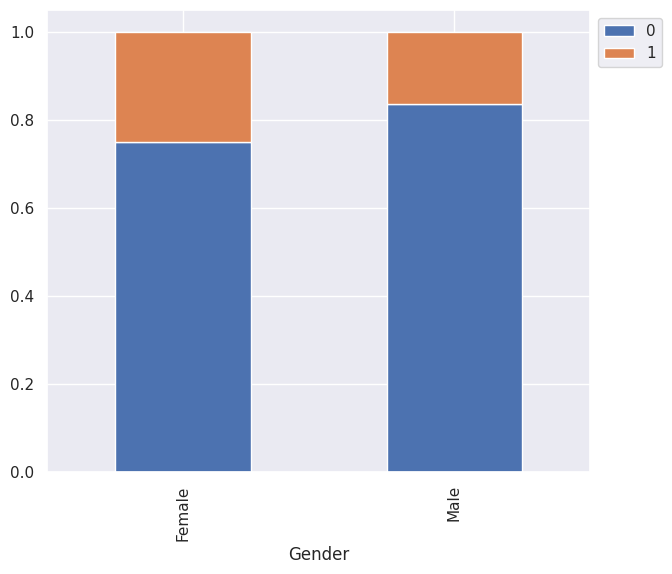

In [ ]:
stacked_barplot(data, "Gender","Exited")

25% or women leave compared to 17% of men

Exited        0     1    All
Geography                   
All        7963  2037  10000
Germany    1695   814   2509
France     4204   810   5014
Spain      2064   413   2477
------------------------------------------------------------------------------------------------------------------------


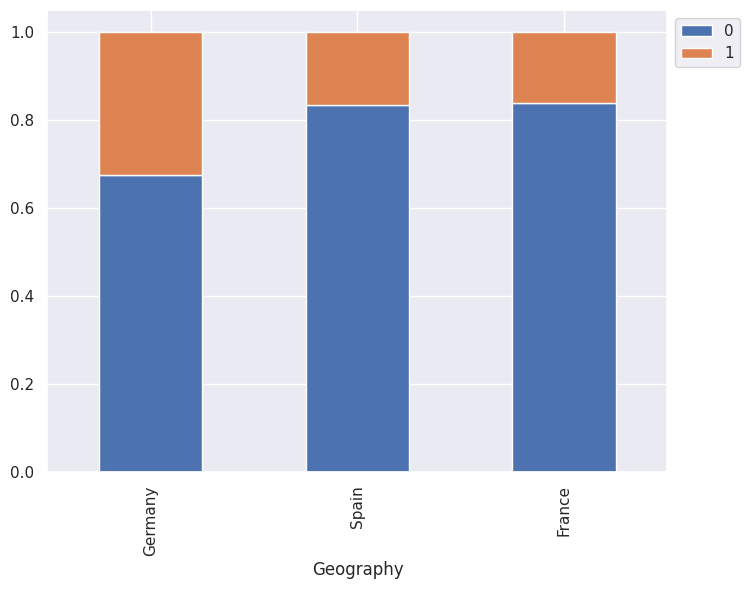

In [ ]:
stacked_barplot(data, "Geography","Exited")

32% of Germans leave compared to 16% of French people and 17% of those in Spain. Gemrans twics as likely to leave

Illustrate the insights based on EDA
-Key meaningful observations from Bivariate analysis

1) most of our customers are still with us so we are doing something right
2)Mst have a credit card and msot have 1-2 products
3) France has over hald our customers, market to them
4) 35% or so have almost no or no balance, making us litlte if any money
5) income and years with us are pretty consitant
6) we have some older people but most seem 25-40 years old
7)creidt socres are pretty average with a fair number of perfect/almost perfect scores

People are more likely to exit if they have low credit scores, are old (above 40), have a higher account balance,  have 3-4 products, are inactive, are women, or are German

I suggest we market to those with higher credit scores, encourage people to have exactly two products, determine if women are leaving due to account mergers (marriage) or for other reasons, figure out if Germans are leaving due to language problems or other reasons, and figure out why people with higher balances are leaving.


Data Pre-processing
- Split the target variable and predictors - Split the data into train and test - Rescale the data

In [ ]:
## Storing required categorical variables in cat_dat to apply dummification
cat_data = ['Geography','Gender']
data = pd.get_dummies(data,columns=cat_data,drop_first= True)


In [ ]:
#again, ke is exit as we want to see how we can prevent this from occuring
##Splitting Independent and dependent variable in X and Y respectively
X = data.drop(['Exited'],axis=1)
Y = data[['Exited']]
print(X.shape)
print(Y.shape)


(10000, 11)
(10000, 1)


In [ ]:
# Splitting the dataset into the Training and Testing set.

X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size = 0.3, random_state = 42)



In [ ]:
X_train.shape #look at what the training data looks like

(7000, 11)

In [ ]:
X_train.head() #see a sample of the train, make sure exited isn't there

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
9069,619,32,4,175406.13,2,1,1,172792.43,0,1,0
2603,643,34,7,160426.07,1,0,1,188533.11,1,0,0
7738,561,33,6,0.00,2,0,0,173680.39,0,0,1
1579,618,41,8,37702.79,1,1,1,195775.48,1,0,1
5058,714,37,9,148466.93,2,0,1,151280.96,0,0,1


In [ ]:
# Checking the shape
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(7000, 11)
(3000, 11)
(7000, 1)
(3000, 1)


In [ ]:
## Scaling the data
sc=StandardScaler()
scaler = StandardScaler().fit(X_train)
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
X_test

array([[-0.5836166 , -0.65674999, -0.68894811, ...,  1.73734559,
        -0.57779016,  0.91055421],
       [-0.30302599,  0.39028611, -1.38250341, ..., -0.57559072,
        -0.57779016,  0.91055421],
       [-0.53165538,  0.48547121, -0.34217046, ..., -0.57559072,
         1.73073215, -1.09823226],
       ...,
       [-0.44851742, -0.65674999,  0.69816249, ..., -0.57559072,
        -0.57779016,  0.91055421],
       [-0.74989252, -0.75193509, -1.03572576, ..., -0.57559072,
        -0.57779016,  0.91055421],
       [-1.23832804, -1.60860099,  1.73849544, ...,  1.73734559,
        -0.57779016, -1.09823226]])

Model building
- Build Neural Network

In [ ]:
import tensorflow.keras as keras
# create a NN with 3 hiden layer
model = keras.Sequential([
keras.layers.Dense(11, input_shape=(11,),kernel_initializer='he_normal', activation='relu'),
keras.layers.BatchNormalization(),
keras.layers.Dense(9, activation='relu'),
keras.layers.BatchNormalization(),
keras.layers.Dense(4, activation='relu'),
keras.layers.BatchNormalization(),
keras.layers.Dense(1,activation='sigmoid')
])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 11)                132       
                                                                 
 batch_normalization_3 (Batc  (None, 11)               44        
 hNormalization)                                                 
                                                                 
 dense_5 (Dense)             (None, 9)                 108       
                                                                 
 batch_normalization_4 (Batc  (None, 9)                36        
 hNormalization)                                                 
                                                                 
 dense_6 (Dense)             (None, 4)                 40        
                                                                 
 batch_normalization_5 (Batc  (None, 4)               

Model Performance Improvement
-Comment on which scaler is right for model performance evaluation and why? - Find the optimal threshold using ROC-AUC curves - Comment on model performance - Can model performance be improved? check and comment - Build another model to implement these improvements - Include all the model which were trained to reach at the final one

In [ ]:

def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)

    if title:
        plt.title(title)

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, precision_recall_curve, auc
#we want to see hoe we can minimize people leaving, thus we don't want a lot of flase negative as we want to see what cause them to leave, not stay
#We want to mimize FP and since this is binary, recall will do will.

optimizer = Adam(0.001)
model.compile(optimizer=optimizer,loss='binary_crossentropy',metrics=['Recall'])
#es_cb = callbacks.EarlyStopping(monitor='val_loss', min_delta=0.001, patience=5)
history = model.fit(X_train, y_train, validation_data=(X_test, y_test),epochs=50)

Epoch 1/50
219/219 [==============================] - 3s 6ms/step - loss: 0.6312 - recall: 0.3950 - val_loss: 0.5277 - val_recall: 0.2329
Epoch 2/50
219/219 [==============================] - 1s 6ms/step - loss: 0.4987 - recall: 0.2402 - val_loss: 0.4503 - val_recall: 0.2842
Epoch 3/50
219/219 [==============================] - 1s 5ms/step - loss: 0.4491 - recall: 0.2478 - val_loss: 0.4205 - val_recall: 0.3168
Epoch 4/50
219/219 [==============================] - 1s 5ms/step - loss: 0.4303 - recall: 0.2650 - val_loss: 0.3997 - val_recall: 0.3271
Epoch 5/50
219/219 [==============================] - 1s 4ms/step - loss: 0.4169 - recall: 0.3083 - val_loss: 0.3859 - val_recall: 0.3493
Epoch 6/50
219/219 [==============================] - 1s 4ms/step - loss: 0.4078 - recall: 0.3441 - val_loss: 0.3758 - val_recall: 0.4127
Epoch 7/50
219/219 [==============================] - 1s 4ms/step - loss: 0.3957 - recall: 0.3778 - val_loss: 0.3692 - val_recall: 0.4144
Epoch 8/50
219/219 [==============

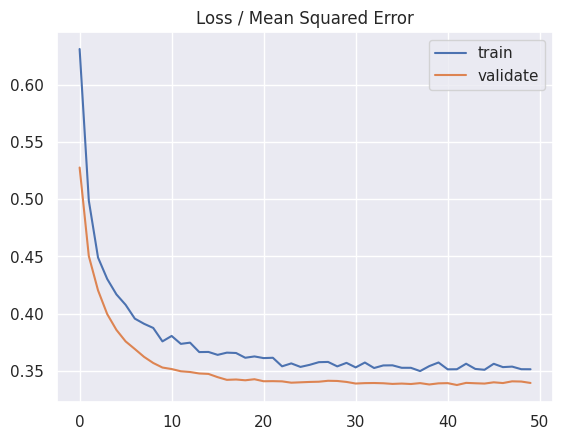

In [ ]:
pyplot.title('Loss / Mean Squared Error')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='validate')
pyplot.legend()
pyplot.show()
#look at the loss over each epoch regardng MSE

Our loss is stable around 0.35, lower for val, this is a good sign. Maybe a little high

94/94 [==============================] - 0s 1ms/step


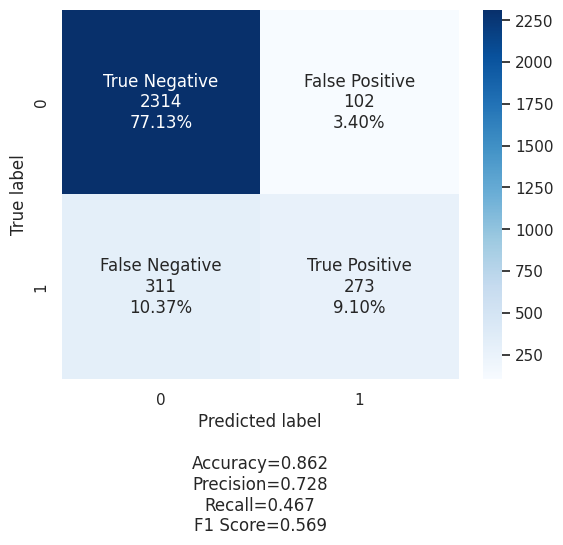

In [ ]:
## Confusion Matrix on unsee test set
import seaborn as sns
y_pred1 = model.predict(X_test) #predict y based on the mode;
for i in range(len(y_test)):
    if y_pred1[i]>0.5:
        y_pred1[i]=1
    else:
        y_pred1[i]=0



cm=confusion_matrix(y_test, y_pred1)
labels = ['True Negative','False Positive','False Negative','True Positive']
#categories = [ 'Not_Fraud','Fraud']
make_confusion_matrix(cm,
                      group_names=labels,
                      #categories=categories,
                      cmap='Blues')

our recall is terrible, lets fix that

94/94 [==============================] - 0s 2ms/step
Best Threshold=0.171950, G-Mean=0.768


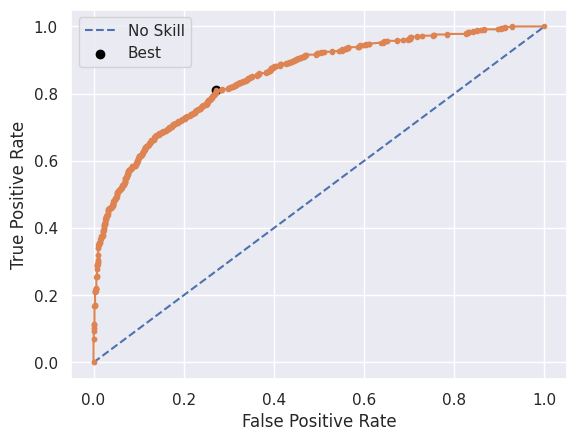

In [ ]:
from sklearn.metrics import roc_curve




# predict probabilities
yhat1 = model.predict(X_test)
# keep probabilities for the positive outcome only
yhat1 = yhat1[:, 0]
# calculate roc curves
fpr, tpr, thresholds1 = roc_curve(y_test, yhat1)
# calculate the g-mean for each threshold
gmeans1 = np.sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = np.argmax(gmeans1)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds1[ix], gmeans1[ix]))
# plot the roc curve for the model
pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
pyplot.plot(fpr, tpr, marker='.')
pyplot.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
# show the plot
pyplot.show()


We have the best index, where the distance to the tope right is least, lets use it to find

In [ ]:
y_pred_e1=model.predict(X_test)
y_pred_e1 = (y_pred_e1 > thresholds1[ix])
y_pred_e1


94/94 [==============================] - 0s 1ms/step


array([[False],
       [False],
       [ True],
       ...,
       [False],
       [False],
       [ True]])

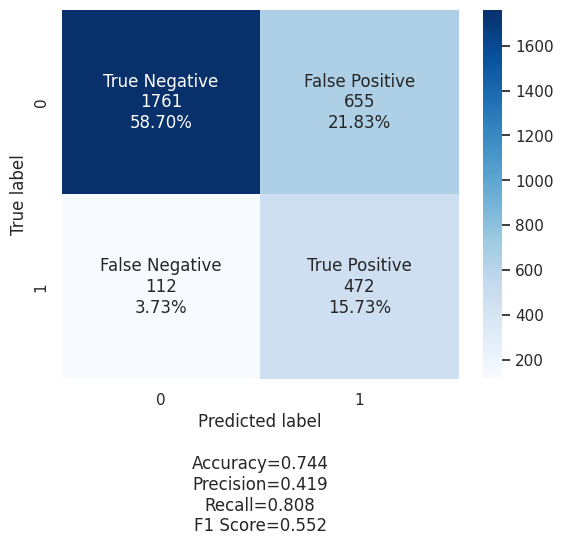

In [ ]:
cm=confusion_matrix(y_test, y_pred_e1)
labels = ['True Negative','False Positive','False Negative','True Positive']
#categories = [ 'Not_Fraud','Fraud']
make_confusion_matrix(cm,
                      group_names=labels,
                      #categories=categories,
                      cmap='Blues')

Much better, but let's keept going. We need to get false positives as close to 0 as possible

I want to to a few thing: add new layer, expand current layer, and add in drop out to see if any work

I will then use rnadom search cv on the best of our models to see if it can get even better

In [ ]:
#add the extra layer
model2 = keras.Sequential([
keras.layers.Dense(11, input_shape=(11,),kernel_initializer='he_normal', activation='relu'),
keras.layers.BatchNormalization(),
keras.layers.Dense(9, activation='relu'),
keras.layers.BatchNormalization(),
keras.layers.Dense(6, activation='relu'),
keras.layers.BatchNormalization(),
keras.layers.Dense(4, activation='relu'),
keras.layers.BatchNormalization(),
keras.layers.Dense(1,activation='sigmoid')
])

In [ ]:
optimizer = Adam(0.001)
model2.compile(optimizer=optimizer,loss='binary_crossentropy',metrics=['Recall'])
#es_cb = callbacks.EarlyStopping(monitor='val_loss', min_delta=0.001, patience=5)
history2 = model2.fit(X_train, y_train, validation_data=(X_test, y_test),epochs=50)

Epoch 1/50
219/219 [==============================] - 5s 8ms/step - loss: 0.6907 - recall: 0.4756 - val_loss: 0.5477 - val_recall: 0.3031
Epoch 2/50
219/219 [==============================] - 1s 5ms/step - loss: 0.5169 - recall: 0.3517 - val_loss: 0.4737 - val_recall: 0.2860
Epoch 3/50
219/219 [==============================] - 1s 4ms/step - loss: 0.4683 - recall: 0.2636 - val_loss: 0.4440 - val_recall: 0.2877
Epoch 4/50
219/219 [==============================] - 1s 4ms/step - loss: 0.4473 - recall: 0.2691 - val_loss: 0.4299 - val_recall: 0.2877
Epoch 5/50
219/219 [==============================] - 1s 4ms/step - loss: 0.4341 - recall: 0.2836 - val_loss: 0.4224 - val_recall: 0.3168
Epoch 6/50
219/219 [==============================] - 1s 4ms/step - loss: 0.4290 - recall: 0.3049 - val_loss: 0.4172 - val_recall: 0.3476
Epoch 7/50
219/219 [==============================] - 1s 4ms/step - loss: 0.4257 - recall: 0.3214 - val_loss: 0.4119 - val_recall: 0.3442
Epoch 8/50
219/219 [==============

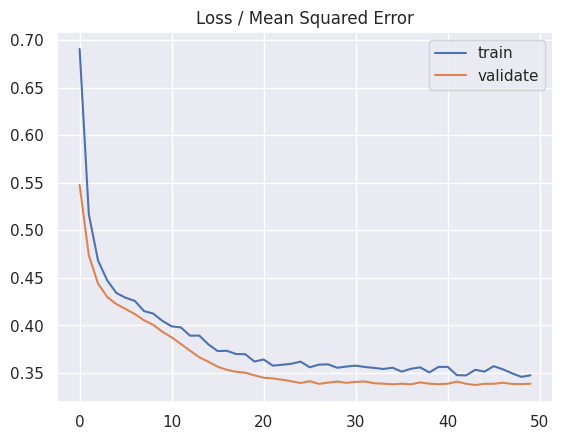

In [ ]:
pyplot.title('Loss / Mean Squared Error')
pyplot.plot(history2.history['loss'], label='train')
pyplot.plot(history2.history['val_loss'], label='validate')
pyplot.legend()
pyplot.show()
#look at the loss over each epoch regardng MSE

Very similat to the original, no improvment that is noteworthy

94/94 [==============================] - 0s 2ms/step
Best Threshold=0.244870, G-Mean=0.768


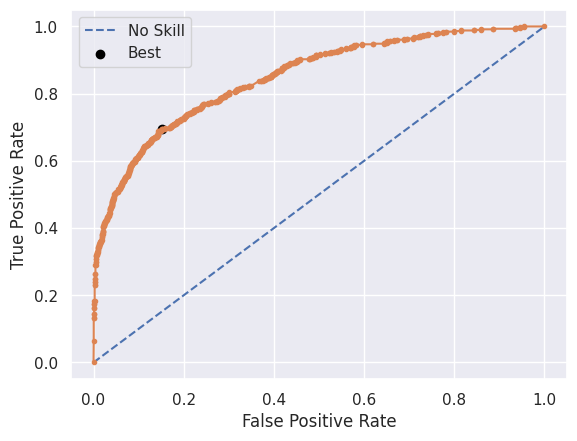

In [ ]:
# predict probabilities
yhat2 = model2.predict(X_test)
# keep probabilities for the positive outcome only
yhat2 = yhat2[:, 0]
# calculate roc curves
fpr, tpr, thresholds2 = roc_curve(y_test, yhat2)
# calculate the g-mean for each threshold
gmeans2 = np.sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = np.argmax(gmeans2)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds2[ix], gmeans2[ix]))
# plot the roc curve for the model
pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
pyplot.plot(fpr, tpr, marker='.')
pyplot.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
# show the plot
pyplot.show()

In [ ]:
y_pred_e2=model2.predict(X_test)
y_pred_e2 = (y_pred_e2 > thresholds2[ix])#predict the y based on new model
y_pred_e2


94/94 [==============================] - 0s 2ms/step


array([[False],
       [False],
       [False],
       ...,
       [False],
       [False],
       [False]])

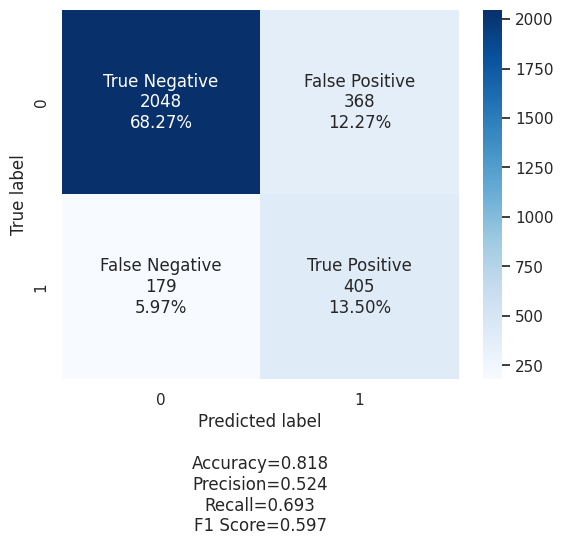

In [ ]:
cm2=confusion_matrix(y_test, y_pred_e2)
labels = ['True Negative','False Positive','False Negative','True Positive']
#categories = [ 'Not_Fraud','Fraud']
make_confusion_matrix(cm2,
                      group_names=labels,
                      #categories=categories,
                      cmap='Blues')

A little worse, remove extra layer

In [ ]:
#create larger layer (2x)
model3 = keras.Sequential([
keras.layers.Dense(22, input_shape=(11,),kernel_initializer='he_normal', activation='relu'),
keras.layers.BatchNormalization(),
keras.layers.Dense(18, activation='relu'),
keras.layers.BatchNormalization(),
keras.layers.Dense(12, activation='relu'),
keras.layers.BatchNormalization(),
keras.layers.Dense(1,activation='sigmoid')
])

In [ ]:
optimizer = Adam(0.001)
model3.compile(optimizer=optimizer,loss='binary_crossentropy',metrics=['Precision'])
#es_cb = callbacks.EarlyStopping(monitor='val_loss', min_delta=0.001, patience=5)
history3 = model3.fit(X_train, y_train, validation_data=(X_test, y_test),epochs=50)

Epoch 1/50
219/219 [==============================] - 5s 9ms/step - loss: 0.5786 - precision: 0.3675 - val_loss: 0.4685 - val_precision: 0.5383
Epoch 2/50
219/219 [==============================] - 1s 6ms/step - loss: 0.4502 - precision: 0.5650 - val_loss: 0.4086 - val_precision: 0.6426
Epoch 3/50
219/219 [==============================] - 1s 6ms/step - loss: 0.4184 - precision: 0.6503 - val_loss: 0.3844 - val_precision: 0.6865
Epoch 4/50
219/219 [==============================] - 1s 5ms/step - loss: 0.4041 - precision: 0.6602 - val_loss: 0.3696 - val_precision: 0.6942
Epoch 5/50
219/219 [==============================] - 1s 6ms/step - loss: 0.3923 - precision: 0.6642 - val_loss: 0.3596 - val_precision: 0.6734
Epoch 6/50
219/219 [==============================] - 1s 6ms/step - loss: 0.3823 - precision: 0.6822 - val_loss: 0.3535 - val_precision: 0.7461
Epoch 7/50
219/219 [==============================] - 1s 4ms/step - loss: 0.3757 - precision: 0.7097 - val_loss: 0.3490 - val_precision:

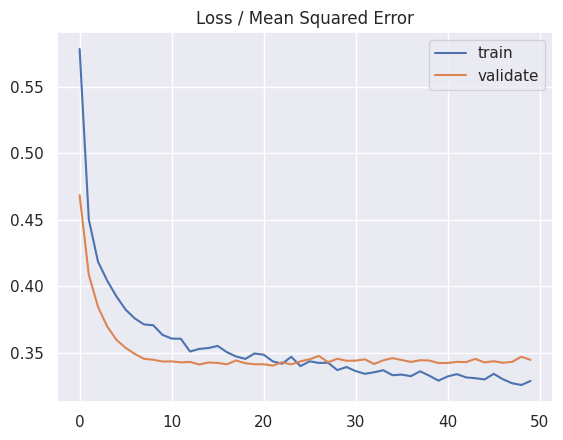

In [ ]:
pyplot.title('Loss / Mean Squared Error')
pyplot.plot(history3.history['loss'], label='train')
pyplot.plot(history3.history['val_loss'], label='validate')
pyplot.legend()
pyplot.show()
#look at the loss over each epoch regardng MSE

Ttan loss a little lower than val and val seems to be icnreasing.

94/94 [==============================] - 0s 2ms/step
Best Threshold=0.203687, G-Mean=0.768


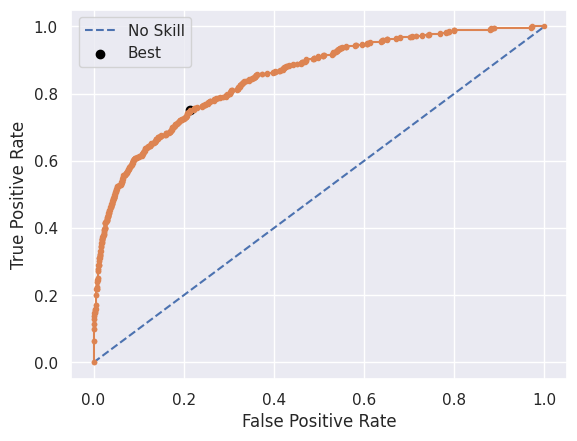

In [ ]:
# predict probabilities
yhat3 = model3.predict(X_test)
# keep probabilities for the positive outcome only
yhat3 = yhat3[:, 0]
# calculate roc curves
fpr, tpr, thresholds3 = roc_curve(y_test, yhat3)
# calculate the g-mean for each threshold
gmeans3 = np.sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = np.argmax(gmeans3)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds3[ix], gmeans3[ix]))
# plot the roc curve for the model
pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
pyplot.plot(fpr, tpr, marker='.')
pyplot.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
# show the plot
pyplot.show()

In [ ]:
y_pred_e3=model3.predict(X_test)
y_pred_e3 = (y_pred_e3 > thresholds3[ix])#predict y based on model
y_pred_e3
#let's see if our trehsold is lower or higher
thresholds3[ix]

94/94 [==============================] - 0s 2ms/step


0.20368674

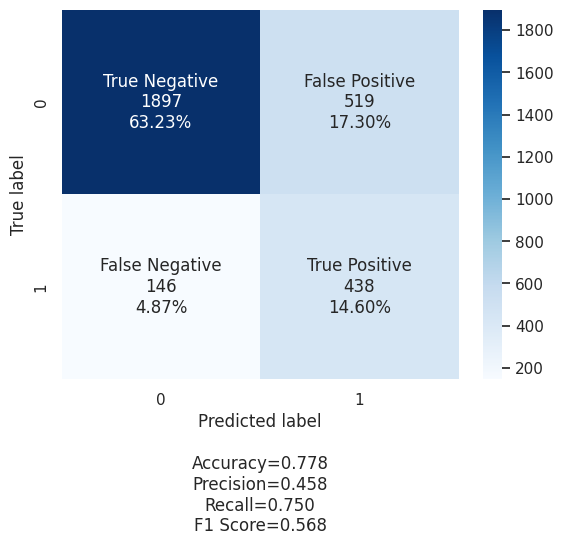

In [ ]:
cm3=confusion_matrix(y_test, y_pred_e3)
labels = ['True Negative','False Positive','False Negative','True Positive']
#categories = [ 'Not_Fraud','Fraud']
make_confusion_matrix(cm3,
                      group_names=labels,
                      #categories=categories,
                      cmap='Blues')

Getting better, keep layers larger

In [ ]:
#create te model with batch and dropout
model4 = keras.Sequential([
keras.layers.Dense(22, input_shape=(11,),kernel_initializer='he_normal', activation='relu'),
keras.layers.BatchNormalization(),
keras.layers.Dropout(0.5),
keras.layers.Dense(18, activation='relu'),
keras.layers.BatchNormalization(),
keras.layers.Dropout(0.5),
keras.layers.Dense(12, activation='relu'),
keras.layers.BatchNormalization(),
keras.layers.Dropout(0.5),
keras.layers.Dropout(0.5),
keras.layers.Dense(1,activation='sigmoid')
])

In [ ]:
optimizer = Adam(0.001)
model4.compile(optimizer=optimizer,loss='binary_crossentropy',metrics=['Recall'])
#es_cb = callbacks.EarlyStopping(monitor='val_loss', min_delta=0.001, patience=5)
history4 = model4.fit(X_train, y_train, validation_data=(X_test, y_test),epochs=50)

Epoch 1/50
219/219 [==============================] - 3s 5ms/step - loss: 1.0383 - recall: 0.3696 - val_loss: 0.5239 - val_recall: 0.0599
Epoch 2/50
219/219 [==============================] - 1s 4ms/step - loss: 0.7296 - recall: 0.2498 - val_loss: 0.4958 - val_recall: 0.0171
Epoch 3/50
219/219 [==============================] - 1s 4ms/step - loss: 0.6173 - recall: 0.1445 - val_loss: 0.4860 - val_recall: 0.0017
Epoch 4/50
219/219 [==============================] - 1s 4ms/step - loss: 0.5566 - recall: 0.0991 - val_loss: 0.4791 - val_recall: 0.0000e+00
Epoch 5/50
219/219 [==============================] - 1s 4ms/step - loss: 0.5446 - recall: 0.0668 - val_loss: 0.4779 - val_recall: 0.0000e+00
Epoch 6/50
219/219 [==============================] - 1s 4ms/step - loss: 0.5280 - recall: 0.0385 - val_loss: 0.4777 - val_recall: 0.0000e+00
Epoch 7/50
219/219 [==============================] - 1s 4ms/step - loss: 0.5141 - recall: 0.0317 - val_loss: 0.4727 - val_recall: 0.0000e+00
Epoch 8/50
219/219

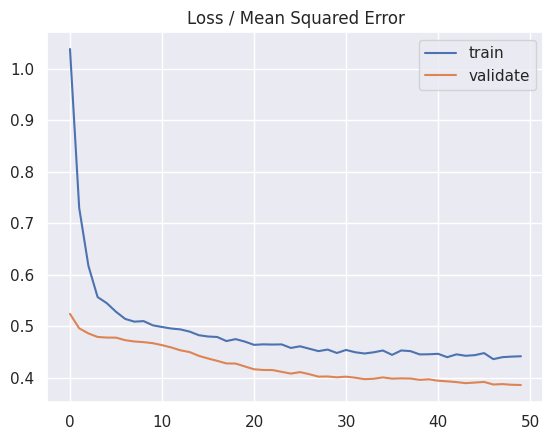

In [ ]:
pyplot.title('Loss / Mean Squared Error')
pyplot.plot(history4.history['loss'], label='train')
pyplot.plot(history4.history['val_loss'], label='validate')
pyplot.legend()
pyplot.show()
#look at the loss over each epoch regardng MSE

Loss is a little higher but is decrasing, after more epochs it MAY be lower than others

94/94 [==============================] - 0s 2ms/step
Best Threshold=0.227989, G-Mean=0.764


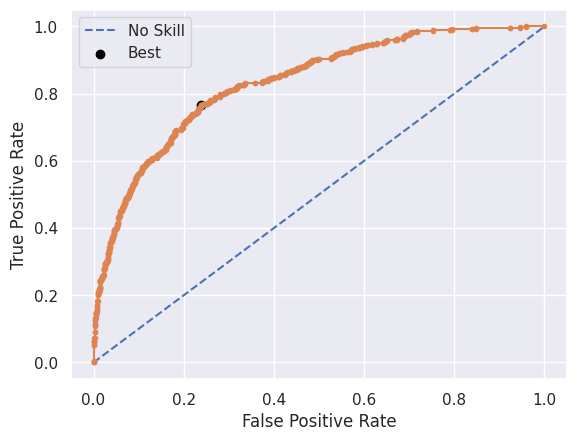

In [ ]:
# predict probabilities
yhat4 = model4.predict(X_test)
# keep probabilities for the positive outcome only
yhat4 = yhat4[:, 0]
# calculate roc curves
fpr, tpr, thresholds4 = roc_curve(y_test, yhat4)
# calculate the g-mean for each threshold
gmeans4 = np.sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = np.argmax(gmeans4)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds4[ix], gmeans4[ix]))
# plot the roc curve for the model
pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
pyplot.plot(fpr, tpr, marker='.')
pyplot.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
# show the plot
pyplot.show()

In [ ]:
y_pred_e4=model4.predict(X_test)
y_pred_e4 = (y_pred_e4 > thresholds4[ix])#predict y based on the model
y_pred_e4
#let's see if our trehsold is lower or higher
thresholds4[ix]

94/94 [==============================] - 0s 3ms/step


0.22798878

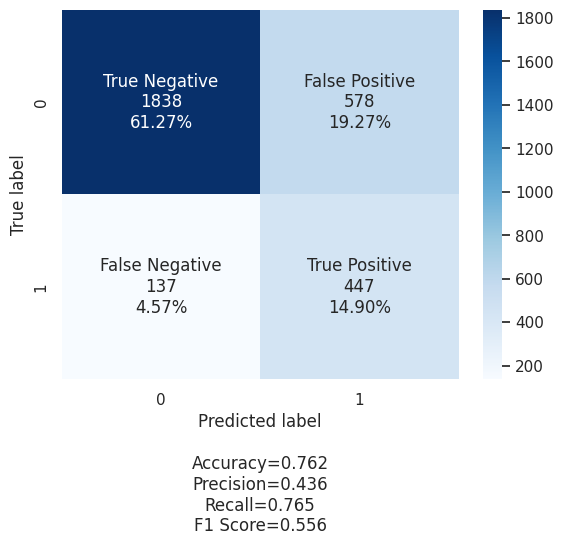

In [ ]:
cm4=confusion_matrix(y_test, y_pred_e4)
labels = ['True Negative','False Positive','False Negative','True Positive']
#categories = [ 'Not_Fraud','Fraud']
make_confusion_matrix(cm4,
                      group_names=labels,
                      #categories=categories,
                      cmap='Blues')

Recall is a little wors,e don't use dropout
Grib search CV

In [ ]:
backend.clear_session()#start CV search
np.random.seed(42)
import random
random.seed(42)
tf.random.set_seed(42)


In [ ]:
def create_model_v4(lr,batch_size):
    np.random.seed(1337)
    model =  keras.Sequential([
    keras.layers.Dense(22, input_shape=(11,),kernel_initializer='he_normal', activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(18, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(12, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(1,activation='sigmoid')
    ])
    #compile model
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(optimizer = optimizer,loss = 'binary_crossentropy', metrics = ['Precision'])
    return model



Use Grid Search CV to optimize learning rate and batch size

In [ ]:
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV
keras_estimator = KerasClassifier(build_fn=create_model_v4, verbose=1)
# define the grid search parameters
param_random = {
    'batch_size':[32, 64, 128],
    "lr":[0.01,0.1,0.001],}

kfold_splits = 3
random= RandomizedSearchCV(estimator=keras_estimator,
                    verbose=1,
                    cv=kfold_splits,
                    param_distributions=param_random,n_jobs=-1)


In [ ]:
random_result = random.fit(X_train, y_train,validation_split=0.2,verbose=1)

# Summarize results
print("Best: %f using %s" % (random_result.best_score_, random_result.best_params_))
means = random_result.cv_results_['mean_test_score']
stds = random_result.cv_results_['std_test_score']
params = random_result.cv_results_['params']


Fitting 3 folds for each of 9 candidates, totalling 27 fits
175/175 [==============================] - 3s 6ms/step - loss: 0.4707 - precision: 0.4794 - val_loss: 0.3887 - val_precision: 0.7122
Best: nan using {'lr': 0.01, 'batch_size': 32}


In [ ]:
estimator_v4=create_model_v4(batch_size=random_result.best_params_['batch_size'],lr=random_result.best_params_['lr'])

estimator_v4.summary()
#now that we have best paramaters we should now create the final model using them


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 22)                264       
                                                                 
 batch_normalization_3 (Batc  (None, 22)               88        
 hNormalization)                                                 
                                                                 
 dense_5 (Dense)             (None, 18)                414       
                                                                 
 batch_normalization_4 (Batc  (None, 18)               72        
 hNormalization)                                                 
                                                                 
 dense_6 (Dense)             (None, 12)                228       
                                                                 
 batch_normalization_5 (Batc  (None, 12)              

In [ ]:
optimizer = tf.keras.optimizers.Adam(random_result.best_params_['lr'])
estimator_v4.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['Recall'])
history5=estimator_v4.fit(X_train, y_train, epochs=50, batch_size = 64,verbose=1,validation_split=0.2)

Epoch 1/50
88/88 [==============================] - 3s 8ms/step - loss: 0.4622 - recall: 0.3433 - val_loss: 0.4042 - val_recall: 0.4375
Epoch 2/50
88/88 [==============================] - 0s 3ms/step - loss: 0.3688 - recall: 0.4232 - val_loss: 0.3594 - val_recall: 0.4722
Epoch 3/50
88/88 [==============================] - 0s 4ms/step - loss: 0.3568 - recall: 0.4704 - val_loss: 0.3572 - val_recall: 0.4757
Epoch 4/50
88/88 [==============================] - 0s 3ms/step - loss: 0.3511 - recall: 0.4764 - val_loss: 0.3693 - val_recall: 0.5208
Epoch 5/50
88/88 [==============================] - 0s 4ms/step - loss: 0.3533 - recall: 0.4747 - val_loss: 0.3559 - val_recall: 0.4583
Epoch 6/50
88/88 [==============================] - 0s 4ms/step - loss: 0.3500 - recall: 0.4798 - val_loss: 0.3559 - val_recall: 0.5000
Epoch 7/50
88/88 [==============================] - 0s 3ms/step - loss: 0.3475 - recall: 0.4781 - val_loss: 0.3574 - val_recall: 0.4236
Epoch 8/50
88/88 [==============================

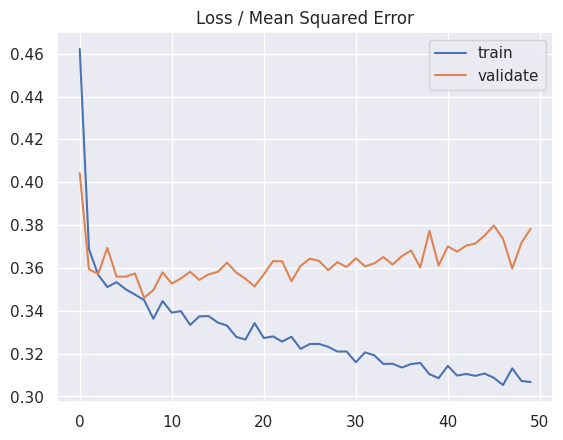

In [ ]:
pyplot.title('Loss / Mean Squared Error')
pyplot.plot(history5.history['loss'], label='train')
pyplot.plot(history5.history['val_loss'], label='validate')
pyplot.legend()
pyplot.show()
#look at the loss over each epoch regardng MSE

Besy tain loss but val loss is higher. bith very unstable and thus may not be reliable

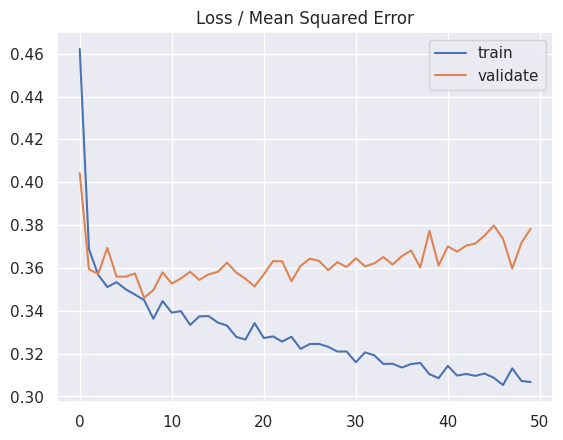

In [ ]:
pyplot.title('Loss / Mean Squared Error')
pyplot.plot(history5.history['loss'], label='train')
pyplot.plot(history5.history['val_loss'], label='validate')
pyplot.legend()
pyplot.show()
#look at the loss over each epoch regardng MSE

94/94 [==============================] - 0s 2ms/step
Best Threshold=0.319735, G-Mean=0.773


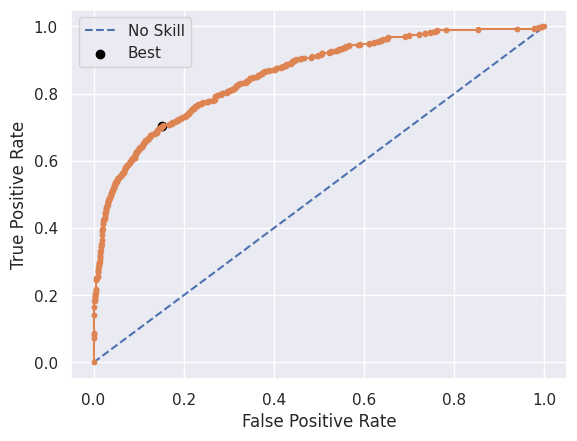

In [ ]:
# predict probabilities
yhat5 = estimator_v4.predict(X_test)
# keep probabilities for the positive outcome only
yhat5 = yhat5[:, 0]
# calculate roc curves
fpr, tpr, thresholds5 = roc_curve(y_test, yhat5)
# calculate the g-mean for each threshold
gmeans5 = np.sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = np.argmax(gmeans5)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds5[ix], gmeans5[ix]))
# plot the roc curve for the model
pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
pyplot.plot(fpr, tpr, marker='.')
pyplot.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
# show the plot


In [ ]:
y_pred_e5=estimator_v4.predict(X_test)#predict the new y
y_pred_e5 = (y_pred_e5 >= thresholds5[ix])
y_pred_e5

94/94 [==============================] - 0s 2ms/step


array([[False],
       [False],
       [False],
       ...,
       [False],
       [False],
       [False]])

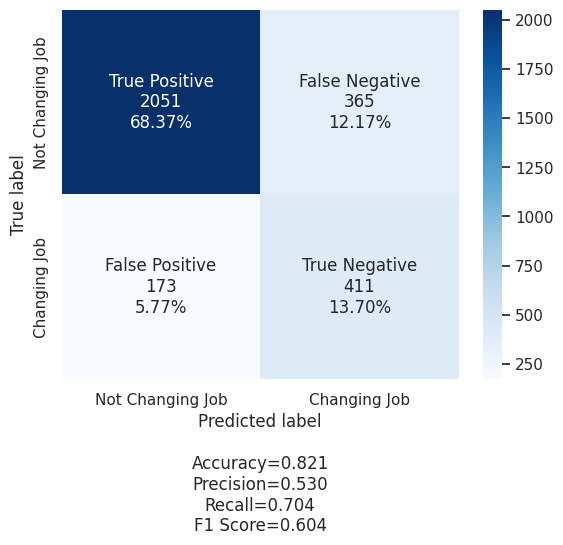

In [ ]:
#Calculating the confusion matrix

cm5=confusion_matrix(y_test, y_pred_e5)
labels = ['True Positive','False Negative','False Positive','True Negative']
categories = [ 'Not Changing Job','Changing Job']
make_confusion_matrix(cm5,
                      group_names=labels,
                      categories=categories,
                      cmap='Blues')


A little worse than our best precision.

CV random search

In [ ]:
backend.clear_session()
np.random.seed(42)
import random
random.seed(42)
tf.random.set_seed(42)

Use random cv search to optimize learning rate and batch size

In [ ]:
def create_model_v5(lr,batch_size):
    np.random.seed(1337)
    model = keras.Sequential([
    keras.layers.Dense(22, input_shape=(11,),kernel_initializer='he_normal', activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(18, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(8, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(1,activation='sigmoid')
    ])

    #compile model
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(optimizer = optimizer,loss = 'binary_crossentropy', metrics = ['Recall'])
    return model


In [ ]:
keras_estimator = KerasClassifier(build_fn=create_model_v4, verbose=1)
# define the grid search parameters
param_random = {
    'batch_size':[32, 64, 128],
    "lr":[0.01,0.1,0.001],}

kfold_splits = 3
random= RandomizedSearchCV(estimator=keras_estimator,
                    verbose=1,
                    cv=kfold_splits,
                    param_distributions=param_random,n_jobs=-1)


In [ ]:
random_result = random.fit(X_train, y_train,validation_split=0.2,verbose=1)

# Summarize results
print("Best: %f using %s" % (random_result.best_score_, random_result.best_params_))
means = random_result.cv_results_['mean_test_score']
stds = random_result.cv_results_['std_test_score']
params = random_result.cv_results_['params']


Fitting 3 folds for each of 9 candidates, totalling 27 fits
175/175 [==============================] - 3s 5ms/step - loss: 0.4707 - precision: 0.4794 - val_loss: 0.3887 - val_precision: 0.7122
Best: nan using {'lr': 0.01, 'batch_size': 32}


In [ ]:
estimator_v5=create_model_v5(batch_size=random_result.best_params_['batch_size'],lr=random_result.best_params_['lr'])

estimator_v5.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 22)                264       
                                                                 
 batch_normalization_3 (Batc  (None, 22)               88        
 hNormalization)                                                 
                                                                 
 dense_5 (Dense)             (None, 18)                414       
                                                                 
 batch_normalization_4 (Batc  (None, 18)               72        
 hNormalization)                                                 
                                                                 
 dense_6 (Dense)             (None, 8)                 152       
                                                                 
 batch_normalization_5 (Batc  (None, 8)               

In [ ]:
optimizer = tf.keras.optimizers.Adam(random_result.best_params_['lr'])
estimator_v5.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['Recall'])
history6=estimator_v5.fit(X_train, y_train, epochs=50, batch_size = 64, verbose=1,validation_split=0.2)


Epoch 1/50
88/88 [==============================] - 3s 6ms/step - loss: 0.4562 - recall: 0.3691 - val_loss: 0.4008 - val_recall: 0.4896
Epoch 2/50
88/88 [==============================] - 0s 3ms/step - loss: 0.3727 - recall: 0.4215 - val_loss: 0.3596 - val_recall: 0.5312
Epoch 3/50
88/88 [==============================] - 0s 4ms/step - loss: 0.3607 - recall: 0.4584 - val_loss: 0.3573 - val_recall: 0.4410
Epoch 4/50
88/88 [==============================] - 0s 4ms/step - loss: 0.3567 - recall: 0.4592 - val_loss: 0.3778 - val_recall: 0.5590
Epoch 5/50
88/88 [==============================] - 0s 3ms/step - loss: 0.3536 - recall: 0.4850 - val_loss: 0.3589 - val_recall: 0.4340
Epoch 6/50
88/88 [==============================] - 0s 4ms/step - loss: 0.3511 - recall: 0.4618 - val_loss: 0.3516 - val_recall: 0.4375
Epoch 7/50
88/88 [==============================] - 0s 4ms/step - loss: 0.3479 - recall: 0.4867 - val_loss: 0.3508 - val_recall: 0.4410
Epoch 8/50
88/88 [==============================

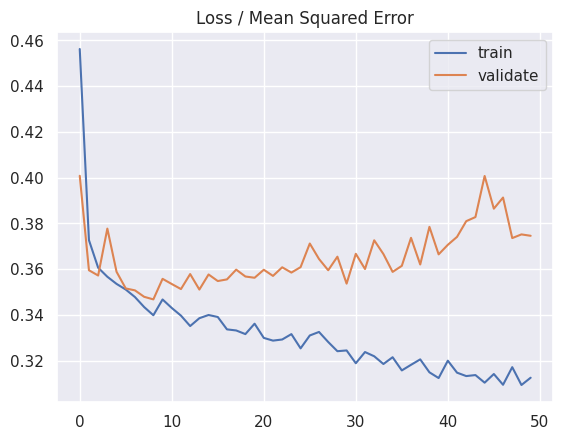

In [ ]:
pyplot.title('Loss / Mean Squared Error')
pyplot.plot(history6.history['loss'], label='train')
pyplot.plot(history6.history['val_loss'], label='validate')
pyplot.legend()
pyplot.show()
#look at the loss over each epoch regardng MSE

Val is increasing fast, this may be a bad sign

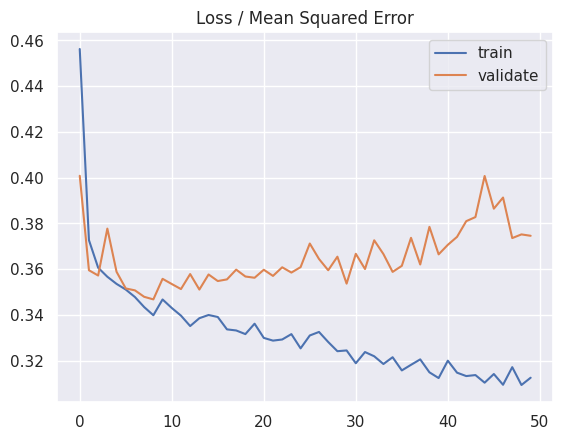

In [ ]:
pyplot.title('Loss / Mean Squared Error')
pyplot.plot(history6.history['loss'], label='train')
pyplot.plot(history6.history['val_loss'], label='validate')
pyplot.legend()
pyplot.show()
#look at the loss over each epoch regardng MSE

94/94 [==============================] - 0s 2ms/step
Best Threshold=0.267033, G-Mean=0.770


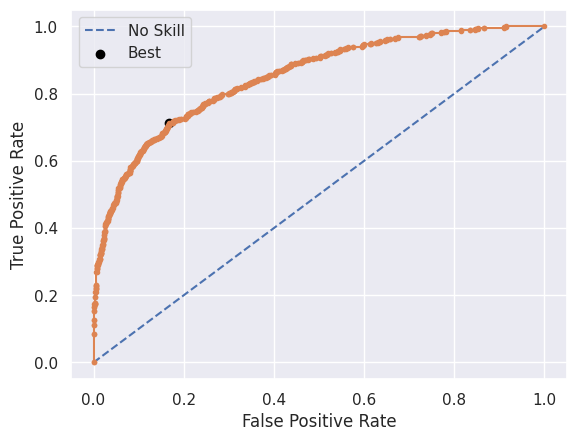

In [ ]:
# predict probabilities
yhat6 = estimator_v5.predict(X_test)
# keep probabilities for the positive outcome only
yhat6 = yhat6[:, 0]
# calculate roc curves
fpr, tpr, thresholds6 = roc_curve(y_test, yhat6)
# calculate the g-mean for each threshold
gmeans6 = np.sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = np.argmax(gmeans6)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds6[ix], gmeans6[ix]))
# plot the roc curve for the model
pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
pyplot.plot(fpr, tpr, marker='.')
pyplot.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
# show the plot
pyplot.show()


In [ ]:
y_pred_e6=estimator_v5.predict(X_test)
y_pred_e6 = (y_pred_e6 > thresholds6[ix])
y_pred_e6

94/94 [==============================] - 0s 3ms/step


array([[False],
       [False],
       [False],
       ...,
       [False],
       [False],
       [False]])

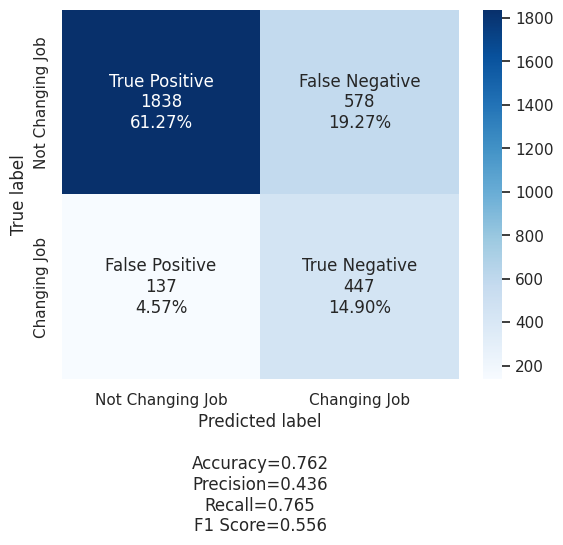

In [ ]:
#Calculating the confusion matrix

cm6=confusion_matrix(y_test, y_pred_e4)
labels = ['True Positive','False Negative','False Positive','True Negative']
categories = [ 'Not Changing Job','Changing Job']
make_confusion_matrix(cm6,
                      group_names=labels,
                      categories=categories,
                      cmap='Blues')


So far the only modle to really impove is larger layers, let's try one more thing

Use dask to see if it is any better

In [ ]:
!pip install dask-ml

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.7/148.7 kB 2.2 MB/s eta 0:00:00


In [ ]:
# importing library
from dask_ml.model_selection import GridSearchCV as DaskGridSearchCV

In [ ]:
def create_model_v6(lr,batch_size):
    np.random.seed(1337)
    model = keras.Sequential([
    keras.layers.Dense(11, input_shape=(11,),kernel_initializer='he_normal', activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(9, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(4, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(1,activation='sigmoid')
    ])


    #compile model
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(optimizer = optimizer,loss = 'binary_crossentropy', metrics = ['accuracy'])
    return model


In [ ]:
keras_estimator = KerasClassifier(build_fn=create_model_v6, verbose=1)
# define the grid search parameters
param_grid = {
    'batch_size':[64,32, 128],
    "lr":[0.001,0.01,0.1],}

kfold_splits = 3
dask = DaskGridSearchCV(estimator=keras_estimator,
                    cv=kfold_splits,
                    param_grid=param_grid,n_jobs=-1)


In [ ]:
import time

# store starting time
begin = time.time()


dask_result = dask.fit(X_train, y_train,validation_split=0.2,verbose=1)

# Summarize results
print("Best: %f using %s" % (dask_result.best_score_, dask_result.best_params_))
means = dask_result.cv_results_['mean_test_score']
stds = dask_result.cv_results_['std_test_score']
params = dask_result.cv_results_['params']

time.sleep(1)
# store end time
end = time.time()

# total time taken
print(f"Total runtime of the program is {end - begin}")


88/88 [==============================] - 2s 6ms/step - loss: 0.5206 - accuracy: 0.7384 - val_loss: 0.4749 - val_accuracy: 0.7943
Best: 0.799000 using {'batch_size': 64, 'lr': 0.01}
Total runtime of the program is 122.88827919960022


This took way too long but I would like to try keras tuner to see if it is better

In [ ]:
!pip install keras-tuner


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 2.7 MB/s eta 0:00:00


In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
from kerastuner.tuners import RandomSearch


In [ ]:
backend.clear_session()
np.random.seed(42)
import random
random.seed(42)
tf.random.set_seed(42)


Earlier he had predefined # of hidden layer, we wil now tune that allong with learning rate and batch size to see if we can improve

In [ ]:
def build_model(h):
    model = keras.Sequential()
    for i in range(h.Int('num_layers', 2, 10)):
        model.add(layers.Dense(units=h.Int('units_' + str(i),
                                            min_value=2,
                                            max_value=36,
                                            step=2),
                               activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(
        optimizer=keras.optimizers.Adam(
            h.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
        loss='binary_crossentropy',
        metrics=['Recall'])#recall needs more weight than anything else as again we care more about fidning people who will leave and not misisng any of them
    return model

In [ ]:
# use rnadom search, tkaes longer but can be better
import keras_tuner
tuner = RandomSearch(
    build_model,
    objective=keras_tuner.Objective("val_recall", direction="max"),
    max_trials=5,
    executions_per_trial=3,
     project_name='Best_params')


In [ ]:
tuner.search(X_train, y_train,
             epochs=5,
             validation_split = 0.2)
#now we want to use training data, which will be split vinto val too, to find bets params

Trial 5 Complete [00h 00m 27s]
val_recall: 0.0

Best val_recall So Far: 0.44212963183720905
Total elapsed time: 00h 02m 23s


In [ ]:
## Printing the best models with their hyperparameters
tuner.results_summary()

Results summary
Results in ./Best_params
Showing 10 best trials
Objective(name="val_recall", direction="max")

Trial 2 summary
Hyperparameters:
num_layers: 9
units_0: 24
units_1: 8
learning_rate: 0.001
units_2: 20
units_3: 4
units_4: 30
units_5: 2
units_6: 32
units_7: 12
units_8: 26
Score: 0.44212963183720905

Trial 3 summary
Hyperparameters:
num_layers: 5
units_0: 4
units_1: 10
learning_rate: 0.01
units_2: 12
units_3: 34
units_4: 34
units_5: 22
units_6: 28
units_7: 30
units_8: 30
Score: 0.4340277711550395

Trial 1 summary
Hyperparameters:
num_layers: 5
units_0: 24
units_1: 20
learning_rate: 0.001
units_2: 32
units_3: 14
units_4: 30
units_5: 8
units_6: 20
units_7: 8
units_8: 2
Score: 0.4270833333333333

Trial 0 summary
Hyperparameters:
num_layers: 9
units_0: 28
units_1: 12
learning_rate: 0.001
units_2: 2
units_3: 2
units_4: 2
units_5: 2
units_6: 2
units_7: 2
units_8: 2
Score: 0.0

Trial 4 summary
Hyperparameters:
num_layers: 10
units_0: 14
units_1: 4
learning_rate: 0.0001
units_2: 22
u

Our best has  hidden  layers  a leanring rate of 0.01 I can't find anything from batch size but 32 has worked well in the past so I will use that. Use layer size from best

In [ ]:
backend.clear_session()
np.random.seed(42)
import random
random.seed(42)
tf.random.set_seed(42)


In [ ]:
#create the new model
model7 = Sequential()
model7.add(Dense(30,activation='relu',kernel_initializer='he_uniform',input_dim = X_train.shape[1]))
model7.add(BatchNormalization())
model7.add(Dense(12,activation='relu',kernel_initializer='he_uniform'))
model7.add(BatchNormalization())
model7.add(Dense(16,activation='relu',kernel_initializer='he_uniform'))
model7.add(BatchNormalization())
model7.add(Dense(24,activation='relu',kernel_initializer='he_uniform'))
model7.add(BatchNormalization())
model7.add(Dense(12,activation='relu',kernel_initializer='he_uniform'))
model7.add(BatchNormalization())
model7.add(Dense(18,activation='relu',kernel_initializer='he_uniform'))
model7.add(BatchNormalization())
model7.add(Dense(28,activation='relu',kernel_initializer='he_uniform'))
model7.add(BatchNormalization())
model7.add(Dense(22,activation='relu',kernel_initializer='he_uniform'))
model7.add(BatchNormalization())
model7.add(Dense(1, activation = 'sigmoid'))


In [ ]:
model7.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 30)                360       
                                                                 
 batch_normalization (BatchN  (None, 30)               120       
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 12)                372       
                                                                 
 batch_normalization_1 (Batc  (None, 12)               48        
 hNormalization)                                                 
                                                                 
 dense_2 (Dense)             (None, 16)                208       
                                                                 
 batch_normalization_2 (Batc  (None, 16)               6

In [ ]:
optimizer = tf.keras.optimizers.Adam(0.001)
model7.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['Recall'])


In [ ]:
history_7 = model7.fit(X_train,y_train,batch_size=32,epochs=50,verbose=1,validation_split = 0.2)


Epoch 1/50
175/175 [==============================] - 5s 8ms/step - loss: 0.6056 - recall: 0.3047 - val_loss: 0.5063 - val_recall: 0.1701
Epoch 2/50
175/175 [==============================] - 1s 5ms/step - loss: 0.4862 - recall: 0.1794 - val_loss: 0.4602 - val_recall: 0.1736
Epoch 3/50
175/175 [==============================] - 1s 5ms/step - loss: 0.4613 - recall: 0.1734 - val_loss: 0.4374 - val_recall: 0.2188
Epoch 4/50
175/175 [==============================] - 1s 5ms/step - loss: 0.4413 - recall: 0.2223 - val_loss: 0.4236 - val_recall: 0.3472
Epoch 5/50
175/175 [==============================] - 1s 5ms/step - loss: 0.4296 - recall: 0.2721 - val_loss: 0.4164 - val_recall: 0.3611
Epoch 6/50
175/175 [==============================] - 1s 8ms/step - loss: 0.4164 - recall: 0.2970 - val_loss: 0.4040 - val_recall: 0.3368
Epoch 7/50
175/175 [==============================] - 1s 8ms/step - loss: 0.4134 - recall: 0.3047 - val_loss: 0.3960 - val_recall: 0.3160
Epoch 8/50
175/175 [==============

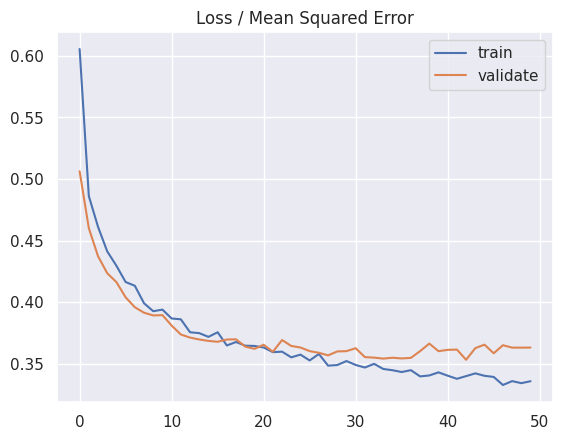

In [ ]:
pyplot.title('Loss / Mean Squared Error')
pyplot.plot(history_7.history['loss'], label='train')
pyplot.plot(history_7.history['val_loss'], label='validate')
pyplot.legend()
pyplot.show()
#look at the loss over each epoch regardng MSE

A little unsatable not not as bad as before. val may stablizie around here but it's hard to tell for sure

94/94 [==============================] - 1s 3ms/step
Best Threshold=0.267684, G-Mean=0.770


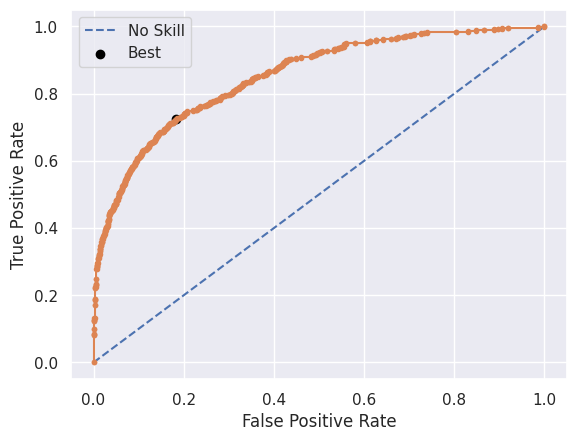

In [ ]:
# predict probabilities
yhat7 = model7.predict(X_test)
# keep probabilities for the positive outcome only
yhat7 = yhat7[:, 0]
# calculate roc curves
fpr, tpr, thresholds7 = roc_curve(y_test, yhat7)
# calculate the g-mean for each threshold
gmeans7 = np.sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = np.argmax(gmeans7)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds7[ix], gmeans7[ix]))
# plot the roc curve for the model
pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
pyplot.plot(fpr, tpr, marker='.')
pyplot.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
# show the plot
pyplot.show()

In [ ]:
y_pred_e7=model7.predict(X_test)
y_pred_e7 = (y_pred_e7 > thresholds7[ix])
y_pred_e7

94/94 [==============================] - 0s 2ms/step


array([[False],
       [False],
       [False],
       ...,
       [False],
       [False],
       [False]])

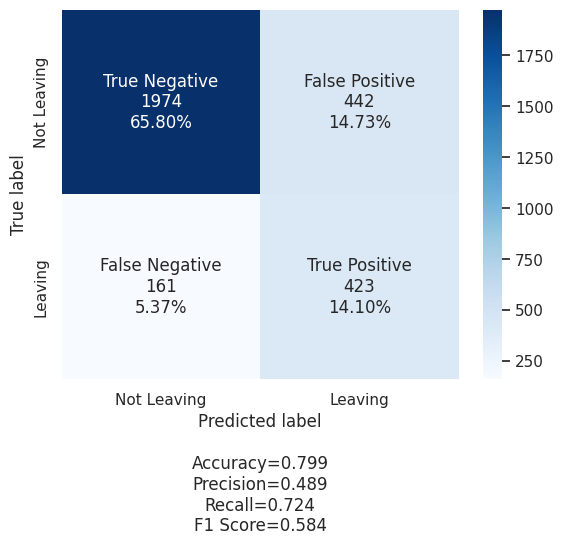

In [ ]:
cm7=confusion_matrix(y_test, y_pred_e7)
labels = ['True Negative','False Positive','False Negative','True Positive']
categories = [ 'Not Leaving','Leaving']
make_confusion_matrix(cm7,
                      group_names=labels,
                      categories=categories,
                      cmap='Blues')

After all this, it is exactly the same as cm2 for recall but our accuracy is a little better so I will consider this to be outr best model

Model Performance Evaluation
- Evaluate the model on different performance metrics and comment on the performance and scope of improvement

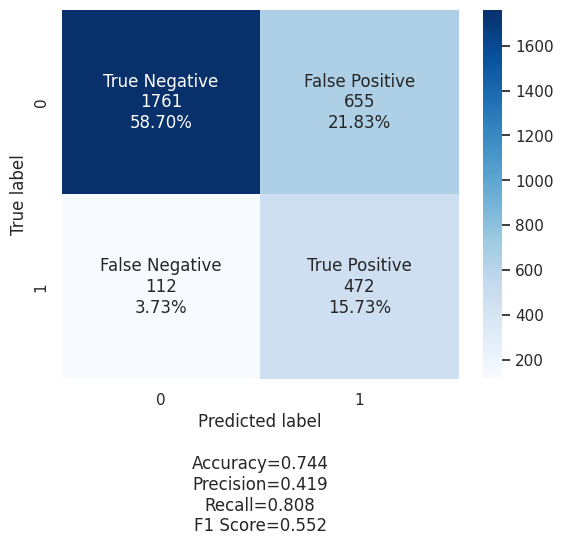

In [ ]:
cm=confusion_matrix(y_test, y_pred_e1)
labels = ['True Negative','False Positive','False Negative','True Positive']
#categories = [ 'Not_Fraud','Fraud']
make_confusion_matrix(cm,
                      group_names=labels,
                      #categories=categories,
                      cmap='Blues')

Accuracy: went slighly down
Precision: went down.
These two are due to larger number of false positive. We are identifying loyal cusitmers as attriting

Recall: went up a fair about. We have fewer flase negative, thus we are getting more of our attriting customers

F1 score: a little down due to lower precision

In [ ]:
#Accuracy as per the classification report
from sklearn import metrics
cr10=metrics.classification_report(y_test,y_pred_e7)
print(cr10)

              precision    recall  f1-score   support

           0       0.92      0.82      0.87      2416
           1       0.49      0.72      0.58       584

    accuracy                           0.80      3000
   macro avg       0.71      0.77      0.73      3000
weighted avg       0.84      0.80      0.81      3000



As we can see, the model was much better at predicting 0s than 1s, possible due to larger number of 0s

Overall this model was not great but did well enough. May need more data to truly achieve any degree of high accuracy. The oprtimize dmodel may have a higher recall, but it's other metrics suffered, meaning it didn't really get better overall, just better at predicting who would leave and even that is minimal

Conclusion and key takeaways
- Final conclusion about the analysis

Areas of improvement
- Try removing less important features
- Try getting more customer data.
- Maybe remove outliers from some of the data
- Use larger neural networks
- Use under sampling ( i will try this at the end to see if anything improves)

Overall impression
- Our model is nothing terrible and could be used to see who may leave, but we shouldn'y rely just on it
-We miss almost 20% of those leaving


Buisness  insights

I suggest we market to those with higher credit scores, encourage people to have exactly two products, determine if women are leaving due to account mergers (marriage) or for other reasons, figure out if Germans are leaving due to language problems or other reasons, and figure out why people with higher balances are leaving

New stuff: see if we can figure out why we are missing so many people

In [ ]:
from imblearn.under_sampling import RandomUnderSampler#get random under sampler
# fit random under sampler on the train data
rus = RandomUnderSampler(random_state=1, sampling_strategy = 1)
X_train_un, y_train_un = rus.fit_resample(X_train, y_train)

In [ ]:
# use rnadom search, tkaes longer but can be better
import keras_tuner
tuner2 = RandomSearch(
    build_model,
    objective=keras_tuner.Objective("val_recall", direction="max"),
    max_trials=5,
    executions_per_trial=3,
     project_name='Best_params2')
tuner2.search(X_train_un, y_train_un,
             epochs=5,
             validation_split = 0.2)
#now we want to use training data, which will be split vinto val too, to find bets params

Trial 5 Complete [00h 00m 16s]
val_recall: 0.3224513257543246

Best val_recall So Far: 0.6134020686149597
Total elapsed time: 00h 01m 11s


In [ ]:
## Printing the best models with their hyperparameters
tuner2.results_summary()

Results summary
Results in ./Best_params2
Showing 10 best trials
Objective(name="val_recall", direction="max")

Trial 3 summary
Hyperparameters:
num_layers: 5
units_0: 30
units_1: 16
learning_rate: 0.001
units_2: 16
units_3: 20
units_4: 20
units_5: 28
Score: 0.6134020686149597

Trial 2 summary
Hyperparameters:
num_layers: 2
units_0: 10
units_1: 30
learning_rate: 0.0001
units_2: 24
units_3: 4
units_4: 2
units_5: 26
Score: 0.5790377954641978

Trial 1 summary
Hyperparameters:
num_layers: 6
units_0: 20
units_1: 8
learning_rate: 0.001
units_2: 28
units_3: 22
units_4: 2
units_5: 2
Score: 0.5189003249009451

Trial 4 summary
Hyperparameters:
num_layers: 6
units_0: 8
units_1: 12
learning_rate: 0.0001
units_2: 36
units_3: 28
units_4: 28
units_5: 26
Score: 0.3224513257543246

Trial 0 summary
Hyperparameters:
num_layers: 4
units_0: 10
units_1: 14
learning_rate: 0.0001
units_2: 2
units_3: 2
Score: 0.10939290126164754


In [ ]:
# we have a new model with 10 hidden layer and learnin rate of 0.0001
backend.clear_session()
np.random.seed(42)
import random
random.seed(42)
tf.random.set_seed(42)

In [ ]:
#very different than model 7
model8 = Sequential()
model8.add(Dense(14,activation='relu',kernel_initializer='he_uniform',input_dim = X_train.shape[1]))
model8.add(BatchNormalization())
model8.add(Dense(20,activation='relu',kernel_initializer='he_uniform'))
model8.add(BatchNormalization())
model8.add(Dense(16,activation='relu',kernel_initializer='he_uniform'))
model8.add(BatchNormalization())
model8.add(Dense(6,activation='relu',kernel_initializer='he_uniform'))
model8.add(BatchNormalization())
model8.add(Dense(8,activation='relu',kernel_initializer='he_uniform'))
model8.add(BatchNormalization())
model8.add(Dense(14,activation='relu',kernel_initializer='he_uniform'))
model8.add(BatchNormalization())
model8.add(Dense(28,activation='relu',kernel_initializer='he_uniform'))
model8.add(BatchNormalization())
model8.add(Dense(2,activation='relu',kernel_initializer='he_uniform'))
model8.add(BatchNormalization())
model8.add(Dense(2,activation='relu',kernel_initializer='he_uniform'))
model8.add(BatchNormalization())
model8.add(Dense(2,activation='relu',kernel_initializer='he_uniform'))
model8.add(BatchNormalization())
model8.add(Dense(1, activation = 'sigmoid'))


In [ ]:
optimizer = tf.keras.optimizers.Adam(0.0001)
model8.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['Recall'])

history_8 = model8.fit(X_train_un,y_train_un,batch_size=32,epochs=50,verbose=1,validation_split = 0.2)


Epoch 1/50
73/73 [==============================] - 7s 12ms/step - loss: 0.8746 - recall: 0.7095 - val_loss: 0.7063 - val_recall: 0.7680
Epoch 2/50
73/73 [==============================] - 0s 6ms/step - loss: 0.8687 - recall: 0.7026 - val_loss: 0.6628 - val_recall: 0.8694
Epoch 3/50
73/73 [==============================] - 0s 6ms/step - loss: 0.8506 - recall: 0.7222 - val_loss: 0.6840 - val_recall: 0.8110
Epoch 4/50
73/73 [==============================] - 0s 6ms/step - loss: 0.8574 - recall: 0.7003 - val_loss: 0.7335 - val_recall: 0.7612
Epoch 5/50
73/73 [==============================] - 0s 7ms/step - loss: 0.8228 - recall: 0.7256 - val_loss: 0.7858 - val_recall: 0.7320
Epoch 6/50
73/73 [==============================] - 0s 6ms/step - loss: 0.8168 - recall: 0.7222 - val_loss: 0.8053 - val_recall: 0.7320
Epoch 7/50
73/73 [==============================] - 0s 7ms/step - loss: 0.8151 - recall: 0.7107 - val_loss: 0.8238 - val_recall: 0.7285
Epoch 8/50
73/73 [=============================

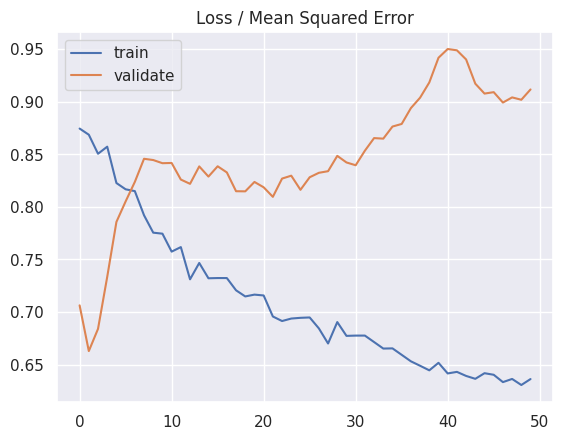

In [ ]:
pyplot.title('Loss / Mean Squared Error')
pyplot.plot(history_8.history['loss'], label='train')
pyplot.plot(history_8.history['val_loss'], label='validate')
pyplot.legend()
pyplot.show()
#look at the loss over each epoch regardng MSE

Very bad but decreasing for tain. Val is icnreasing, this model is not good at all

94/94 [==============================] - 1s 2ms/step
Best Threshold=0.465162, G-Mean=0.572


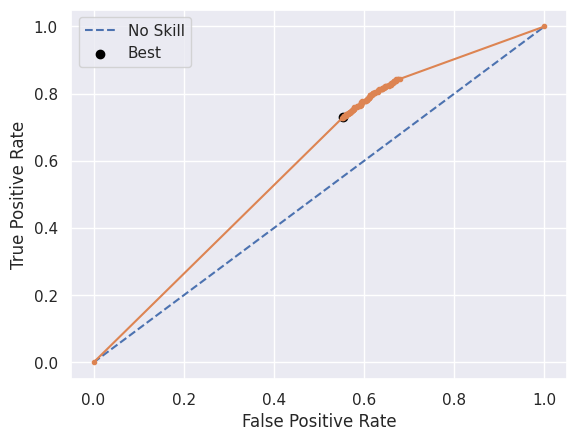

In [ ]:
# predict probabilities
yhat8 = model8.predict(X_test)
# keep probabilities for the positive outcome only
yhat8 = yhat8[:, 0]
# calculate roc curves
fpr, tpr, thresholds8 = roc_curve(y_test, yhat8)
# calculate the g-mean for each threshold
gmeans8 = np.sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = np.argmax(gmeans8)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds8[ix], gmeans8[ix]))
# plot the roc curve for the model
pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
pyplot.plot(fpr, tpr, marker='.')
pyplot.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
# show the plot
pyplot.show()

In [ ]:
y_pred_e8=model8.predict(X_test)
y_pred_e8 = (y_pred_e8 > thresholds8[ix])
y_pred_e8

94/94 [==============================] - 0s 2ms/step


array([[ True],
       [False],
       [ True],
       ...,
       [False],
       [False],
       [ True]])

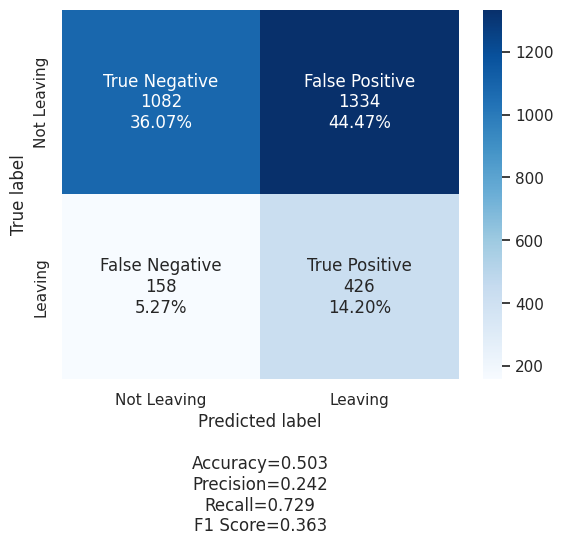

In [ ]:
cm8=confusion_matrix(y_test, y_pred_e8)
labels = ['True Negative','False Positive','False Negative','True Positive']
categories = [ 'Not Leaving','Leaving']
make_confusion_matrix(cm8,
                      group_names=labels,
                      categories=categories,
                      cmap='Blues')

Actually got way worse, barely better than guessing

FInal recommendations:
- get more data to make the model more rleiable
- Try other under and oversmapling mehtods
- offer promotions to those about to leave
- target those with hgih credit scores to open
- engoruage exactly two products
- focus on France and psain as germans leave a lot
- Offer special benefits to older people and maybe women (if research shows they aren't merging acocunts with husband but are leaving) the same cna be done to germans if we want to stay there
- Give more rewards to those with more in their acounts. This will encoruage them to stay and may even encourage others to invest more with us